# Fill in outs 
## June

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os


from src.utils import *
from src.plotting import Baseball_Field
from src.game import Game

In [2]:
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'


## We don't know now many outs there are at any point!

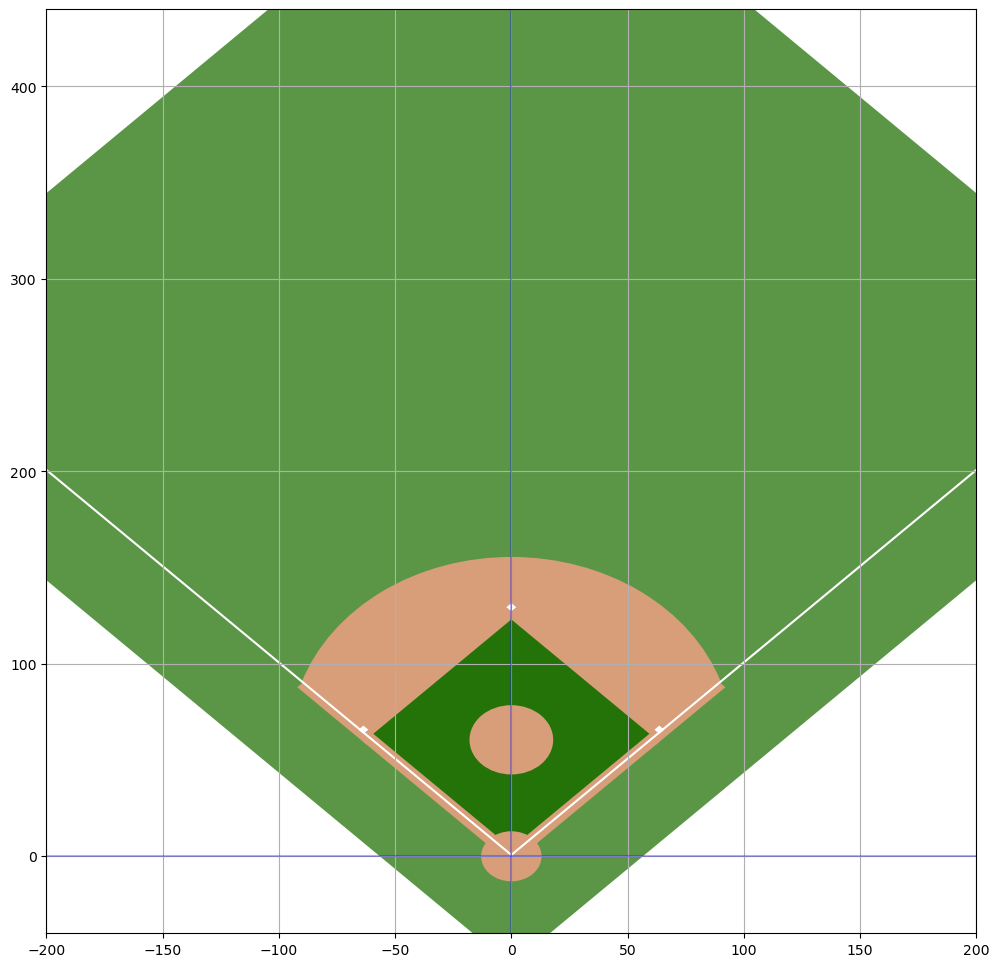

In [3]:
bf_1903_30 = Baseball_Field("1903_30_TeamNB_TeamA1")
game_info_1903_30 = bf_1903_30.game_obj.game_info_df.copy()

## ~~Lean full into the Sudoku solver strategy~~ This is in Game now!


At a high level, I think I need:
- a recursive function that returns true or false
    - a for loop from 0, 2 (inclusive)
- a thing that finds an empty cell
- an "is_valid_outs" function where I enumerate all of my rules


### I think I want to keep the half inning df, but pass around the sequences!

In [4]:
def get_play_id_and_ppg_for_event(game_obj, event, **kwargs):
    """
    takes in a game_events_df
    
    event is "home run", etc
    
    """
    event_indices = game_obj.game_events_df["event"] == event
    
    if len(kwargs) != 0:
        
        for k,v in kwargs.items():
                        
            if type(v) is list:                
                event_indices = (event_indices) & (game_obj.game_events_df[k].isin(v))
                
            else:
                event_indices = (event_indices) & (game_obj.game_events_df[k] == v)
            
    return game_obj.game_events_df.loc[event_indices, ["play_id", "play_per_game"]].drop_duplicates()
    
    

# get_play_id_and_ppg_for_event(bf_1903_30.game_obj, "home run")


get_play_id_and_ppg_for_event(bf_1903_30.game_obj, "ball acquired", player_position=[7, 8, 9], next_event="end of play")



,play_id,play_per_game
40,11,11
202,55,56
349,88,90
445,109,114
475,117,122
507,125,131
518,128,134
536,131,137
802,194,202
1047,255,263


In [5]:
def solve_outs_sequence_seq(game_obj, half_inning_df, seq):
    
    empty_cell_index = find_empty_cell_seq(seq)
    
    if empty_cell_index is None:
        # you have found a valid solution and this is what makes your thing return
        return True
    
    
    for this_play_outs in range(3):
        
        if is_valid_outs_assignment_seq(game_obj, half_inning_df, seq, this_play_outs, empty_cell_index):
            seq[empty_cell_index, 1] = this_play_outs
            
            temp_sum = 0 if empty_cell_index == 0 else sum(seq[empty_cell_index - 1, :])
            
            seq[empty_cell_index, 0] = temp_sum
            
            pass
            
            
            if solve_outs_sequence_seq(game_obj, half_inning_df, seq):
                # you did it!
                return True
        
            seq[empty_cell_index, 0] = np.nan
            seq[empty_cell_index, 1] = np.nan
            
    return False


def find_empty_cell_seq(seq):
        
    index = None
    
    # this play outs is in the second column!
    
    for i, val in enumerate(seq[:, 1]):
        if np.isnan(val):
            return i
    
    return index


def is_valid_outs_assignment_seq(game_obj, half_inning_df, seq, this_play_outs, empty_cell_index):
    
    all_batting_team = ["batter", "first_baserunner", "second_baserunner", "third_baserunner"]
    all_br = ["first_baserunner", "second_baserunner", "third_baserunner"]
    
    seq_len = seq.shape[0]
    
    # debugging
    
    this_row = half_inning_df.iloc[empty_cell_index]
    
    old_set_batting_team = set()
    prev_total_outs = 0
    
    if empty_cell_index != 0:
        # you need to set and check all of the things that look at the prev row 
        old_set_batting_team = set(half_inning_df.iloc[empty_cell_index - 1][all_batting_team])
        prev_total_outs = sum(seq[empty_cell_index - 1, :])
          
    next_batter = None
    next_set_batting_team = set()
    next_set_br = set()
    next_second_br = None
    next_third_br = None
    

    hr_play_per_games = get_play_id_and_ppg_for_event(game_obj, "home run")["play_per_game"].values

    flyouts_that_end_play = get_play_id_and_ppg_for_event(game_obj,
                                                          "ball acquired", 
                                                          player_position=[7, 8, 9],
                                                          next_event="end of play")["play_per_game"].values

    

    if empty_cell_index < seq_len - 1:
        next_batter = half_inning_df.iloc[empty_cell_index + 1]["batter"]
        next_set_batting_team = set(half_inning_df.iloc[empty_cell_index + 1][all_batting_team])
        next_set_br = set(half_inning_df.iloc[empty_cell_index + 1][all_br])
        
        next_second_br = half_inning_df.iloc[empty_cell_index + 1]["second_baserunner"]
        next_third_br = half_inning_df.iloc[empty_cell_index + 1]["third_baserunner"]
    
    this_batter = half_inning_df.iloc[empty_cell_index]["batter"]
    this_set_br = set(half_inning_df.iloc[empty_cell_index][all_br])
    this_first_br = half_inning_df.iloc[empty_cell_index]["first_baserunner"]
    this_second_br = half_inning_df.iloc[empty_cell_index]["second_baserunner"]
    this_third_br = half_inning_df.iloc[empty_cell_index]["third_baserunner"]
    
    
    
    same_batter_next_play = this_batter == next_batter
    
    # Outs has to be the same or more as all previous indices in the sequence
    this_set_batting_team = set(half_inning_df.iloc[empty_cell_index][all_batting_team])
        
    
    does_this_make_3 = prev_total_outs + this_play_outs
    
    this_play_per_game = half_inning_df.iloc[empty_cell_index]["play_per_game"]
    
    # hr_play_per_games = bf_1903_30.game_obj.game_events_df.loc[hr_indices, "play_per_game"].values
    
    ## end debugging
    
    pass
    
    # Assuming consecutive indices!

    
    # TODO: 
    # It can't be an out if the batter is on base next play and a runner scores
    


    if this_play_outs != 0 and this_play_per_game \
        in hr_play_per_games:
        # Outs can't go up on a home run
        return False

    if this_play_outs == 0 and this_batter not in next_set_br \
        and this_batter != next_batter and this_play_per_game not in hr_play_per_games:
        # if the batter is not on the bases when there is a new batter and it wasn't a HR then the batter got out:
    
        return False
    
    
    if this_play_outs > 1 and this_play_per_game in flyouts_that_end_play:
    # if the last thing that happens is a ball being acquired by an outfield, then there can't be more than 1 out on the play
    # this will fail if the outfielders get into a run down and tag someone out for a double play, but that seems super rare
        return False
    
    
    if this_play_outs == 0 and this_batter != next_batter and this_play_per_game not in hr_play_per_games and \
        this_batter in next_set_br and this_first_br not in next_set_br and this_first_br != 0 and \
            ((this_second_br in next_set_br and this_second_br != 0) or (this_third_br in next_set_br and this_third_br != 0)):
        # Outs must go up if there is a runner this isn't on the bases on the next play, and there are were runners ahead of them on this play
        
        # Fielders choice out at second
        
        return False
     
        
    """
     if this_play_outs == 0 and this_batter != next_batter and this_play_per_game not in hr_play_per_games and \
        this_batter in next_set_br and this_second_br not in next_set_br  and this_third_br in next_set_br and this_third_br != "0"):
        
        # Fielders choice out at third
        
        return False
    """
         
    # TODO: Fielders choice out at home??
        
    
        
    if this_play_outs != 1 and set([br for br in this_set_br if br != 0 ]) == set([br for br in next_set_br if br != 0 ]) \
        and this_batter != next_batter:
        # TODO:
        # It must be 1 out if there are non zero BRs that stay the same, and there is a new batter -- this is a strikeout
        # Assumption this goes wrong for mid at bat PH, but that might be rare -- ignore that
        
        return False
    
    
    if this_play_outs != 0 and this_set_batting_team == next_set_batting_team:
    # Outs can't go up is there is the same batter and baserunners
        return False
    
    
    if this_play_outs > (1 + half_inning_df.iloc[empty_cell_index]["n_br"]):
        # Outs can't go up by more than the number of baserunners + 1
        return False
    
    if this_play_outs != 0 \
        and next_set_br == this_set_batting_team:
        # and half_inning_df.iloc[empty_cell_index - 1]["batter"] != 0\ # not sure about this part
        
            # Outs can't go up if the batter becomes the baserunner on the next play 
            # and the previous set of baserunners is still there

            return False
    
    
    if this_play_outs != 0 and len(this_set_batting_team) == 2 and same_batter_next_play:
        # Outs can't go up if there are no baserunners and the batter is the same in the next play
        # len(this_set_batting_team) == 2 is because the set will be batter_num and 0
    
        return False
        
    
    
    if ((seq_len - 1) == (empty_cell_index)) \
        and (does_this_make_3 != 3):
        # if we are on the last index, then this_play_outs and prev_outs must sum to three
        
        return False

    
    
    
    return True



    
    

#### Test case on an obviously 1-2-3 inning

In [6]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 1) & (game_info_1903_30["top_bottom_inning"] == "Top")]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
0,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,1,1,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
1,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,1,2,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
2,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,1,3,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1,1,1
3,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,2,4,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
4,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,2,5,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
5,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,2,6,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
6,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,2,7,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,0,1,1,1,1.0,0.0,0.0,0.0,1,1,1
7,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,3,8,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3718,0,0,0,0,2,0,1,1.0,0.0,0.0,0.0,1,1,1
8,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,3,9,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3718,0,0,0,0,2,0,1,1.0,0.0,0.0,0.0,1,1,1
9,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,3,10,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3718,0,0,0,0,2,0,1,1.0,0.0,0.0,0.0,1,1,1


### Bottom of the first
#### this one seems harder, because there are baserunners, etc

- if something is wrong on this, I think the plan will be to check things like throws and balls acquired, etc


In [7]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 1) & (game_info_1903_30["top_bottom_inning"] == "Bottom")]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
11,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,12,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,0
12,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,13,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,0
13,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,14,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,0
14,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,15,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,0
15,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,16,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,0
16,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,17,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,0
17,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,5,18,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2766,2919,0,0,1,0,0,1,1.0,1.0,0.0,0.0,1,1,0
18,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,5,19,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2766,2919,0,0,1,0,0,1,1.0,1.0,0.0,0.0,1,1,0
19,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,5,20,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2766,2919,0,0,1,0,0,1,1.0,1.0,0.0,0.0,1,1,0
20,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,5,21,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2766,0,2919,0,1,0,0,1,1.0,0.0,1.0,0.0,1,1,0


##### Description of bottom of the first

Brainstorming on how where this is wrong, and what could be done to make it work better
- I think "baserunner scores" could be something?

A description of what is going on rn:

- 20 is an advancement on a passed ball or wild pitch
- 22 is a single that moves the runner to single I think -- its actually a fielding error lol
- 27 is another advancement on a passed ball or wild pitch
- 29 is this an RBI ground out that gets called safe?

- 34 is a single to right, with the runner on third scoring
- 39 is a walk or right?
- 43 is another walk? it was wayyyy outside lol
- 46 should have been a strikeout I think? --- COME UP WITH A STRIKEOUT RULE? Maybe if there is a new batter, and all the br stay the same -- this goes wrong for mid at bat PH, but that might be rare -- 
- 51 is a walk that gets marked a strikeout -- FIX HERE -- It can't be an out if that batter it on base next play
- 56 is a flyout to center field, -- FIX HERE -- it is only one out! 

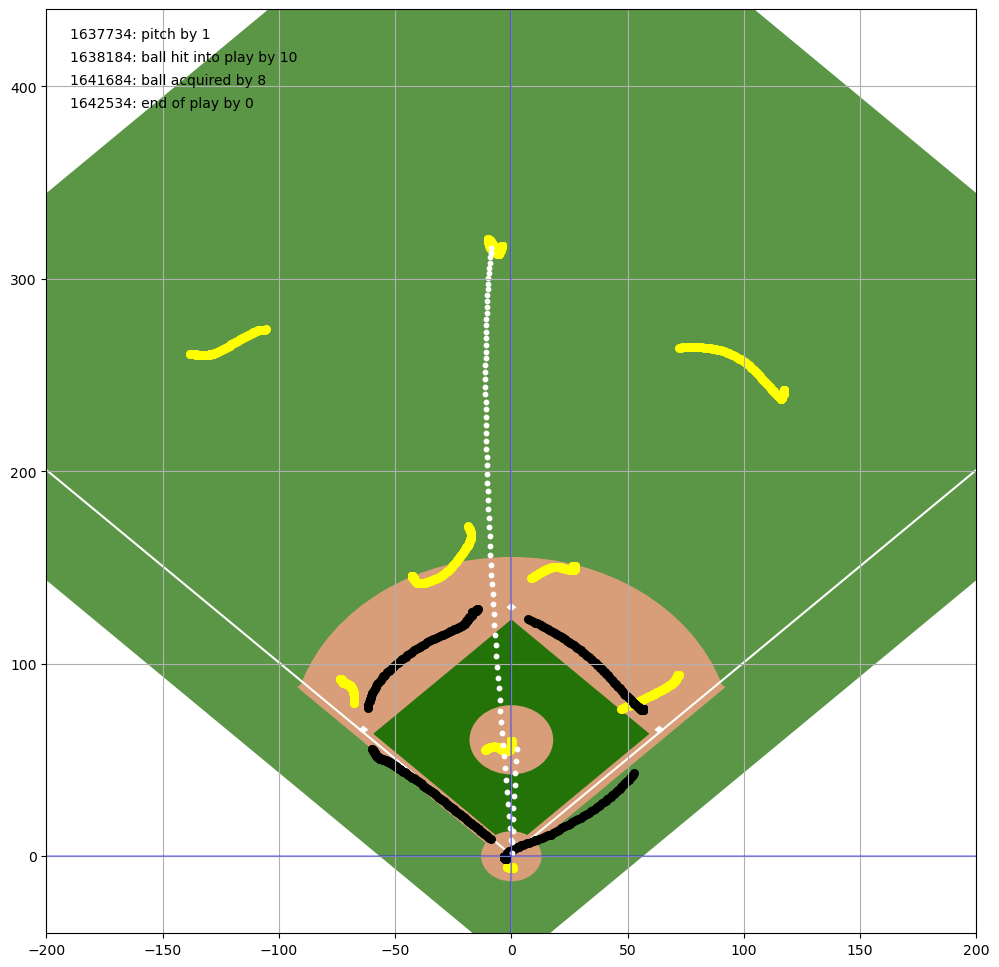

In [8]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(56)

bf_1903_30.plot_all_components(play_id=play_id)

bf_1903_30.fig
# bf_1903_30.create_gif(play_id=play_id, tag="--is this a dp")

### Top of the second

In [9]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 2) & (game_info_1903_30["top_bottom_inning"] == "Top")]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
56,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,14,57,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
57,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,14,58,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
58,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,14,59,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
59,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,14,60,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
60,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,14,61,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
61,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,14,62,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1,1,1
62,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,15,63,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,4794,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
63,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,15,64,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,4794,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
64,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,15,65,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,4794,0,0,0,0,1,1,1,1.0,0.0,0.0,0.0,1,1,1
65,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,16,66,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8079,0,0,0,0,2,0,1,1.0,0.0,0.0,0.0,1,1,1


##### Top of second description

A description of what is going on rn:

- 62 was a 4-3 put out
- 65 is a 6-3 put out
- 69 is a dropped third strike lol
- 75 is 6 unassisted

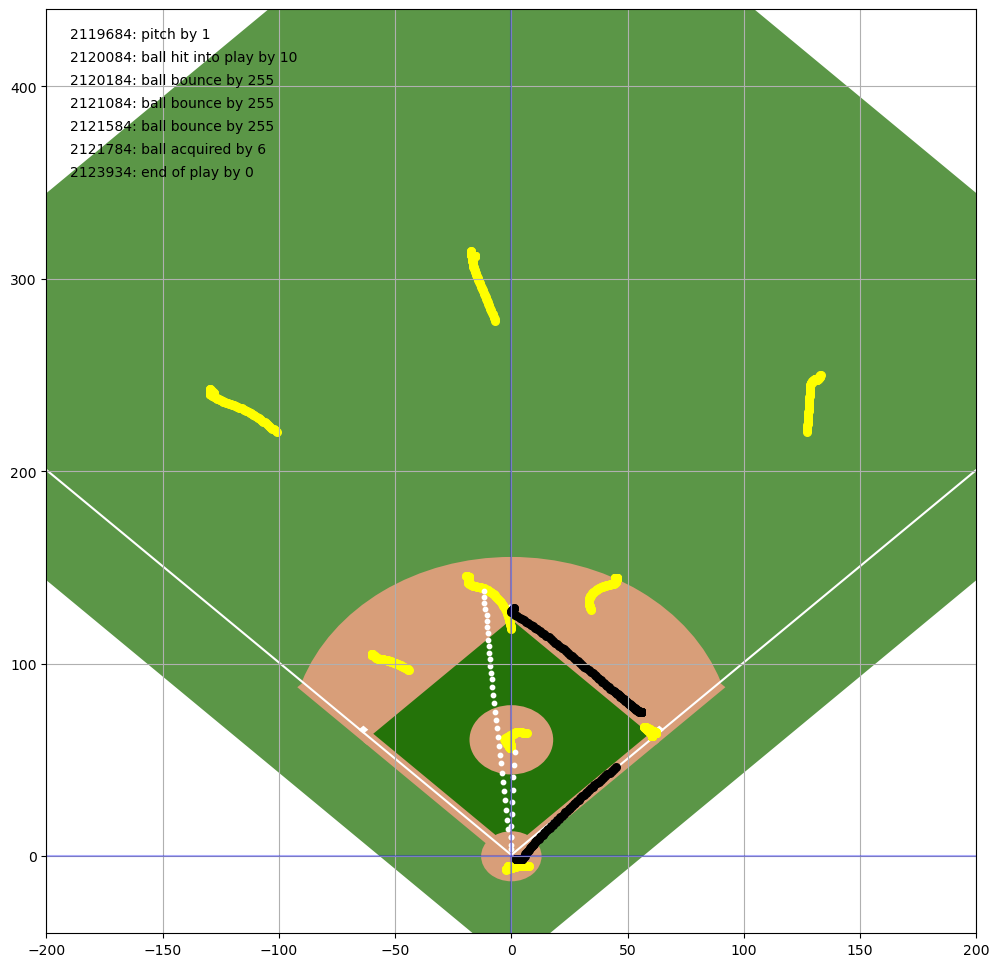

In [10]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(75)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--6_unassisted")

### Bottom of the second

In [11]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 2) & (game_info_1903_30["top_bottom_inning"] == "Bottom")]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
75,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,18,76,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,2766,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
76,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,19,77,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1973,2766,0,0,1,0,0,1,1.0,1.0,0.0,0.0,1,1,1
77,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,19,78,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1973,2766,0,0,1,0,0,1,1.0,1.0,0.0,0.0,1,1,1
78,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,20,79,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1185,0,1973,2766,2,0,0,1,1.0,0.0,1.0,1.0,1,1,1
79,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,21,80,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,0,1185,1,0,0,1,1.0,0.0,0.0,1.0,1,1,1
80,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,21,81,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,0,1185,1,0,0,1,1.0,0.0,0.0,1.0,1,1,1
81,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,21,82,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,0,1185,1,0,0,1,1.0,0.0,0.0,1.0,1,1,1
82,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,21,83,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,0,1185,1,0,0,1,1.0,0.0,0.0,1.0,1,1,1
83,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,22,84,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,2386,1945,0,1185,2,0,0,1,1.0,1.0,0.0,1.0,1,1,1
84,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,22,85,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,2386,1945,0,1185,2,0,1,1,1.0,1.0,0.0,1.0,1,1,1


##### Bottom of second description

A description of what is going on rn:

- 76 is a HBP lol that it counts as a ball deflection
- 78 is a double to left field
- 79 is a triple off the right center wall
- 83 is a walk
- 85 is a sac fly to center
- 87 is a 1-3 sacrifice?
- 90 is a lazy fly to left



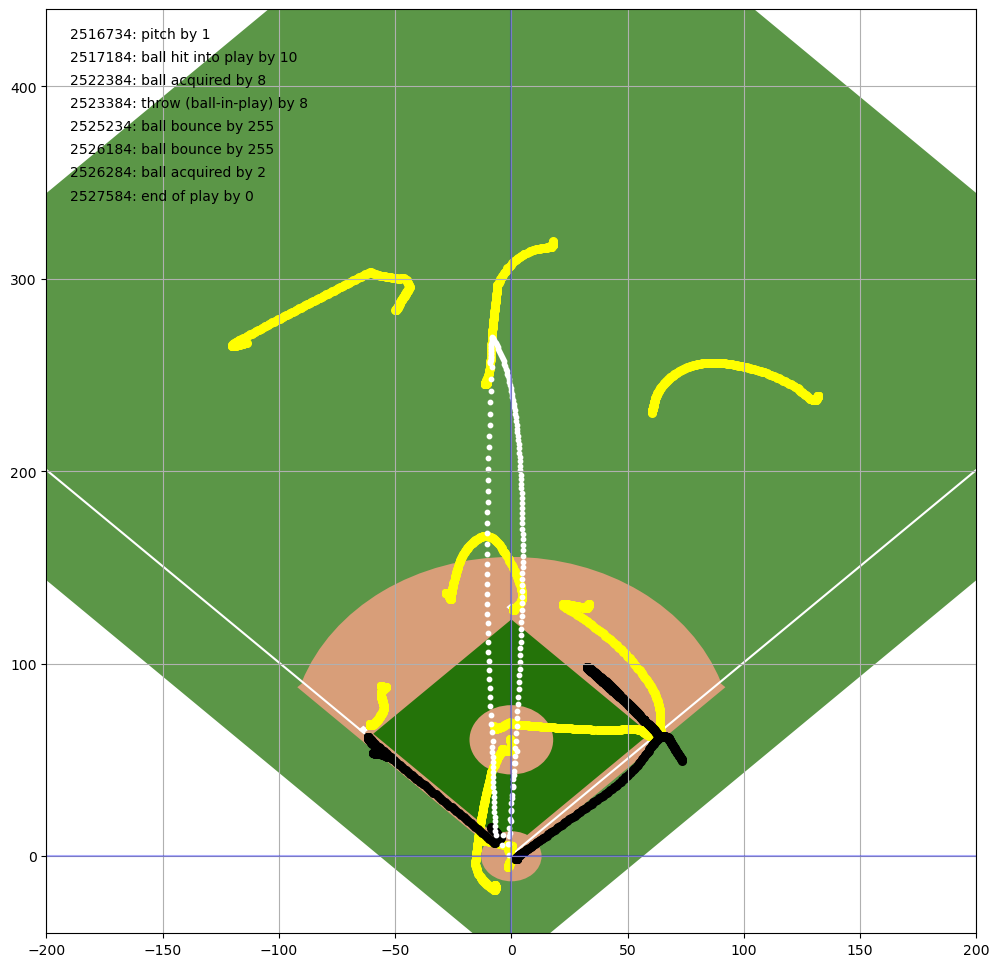

In [12]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(85)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--lazy fly to left")

### Top of 3

In [13]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 3) & (game_info_1903_30["top_bottom_inning"] == "Top")]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
90,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,25,91,3,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3291,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,0
91,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,25,92,3,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3291,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,0
92,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,25,93,3,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3291,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,0
93,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,25,94,3,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3291,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1,1,0
94,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,26,95,3,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3363,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,0
95,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,27,96,3,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,6189,3363,0,0,1,1,0,0,NaN,NaN,NaN,NaN,0,1,0
96,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,27,97,3,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,6189,3363,0,0,1,1,1,0,NaN,NaN,NaN,NaN,0,1,0
97,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,28,98,3,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,3363,0,0,1,2,0,1,1.0,1.0,0.0,0.0,1,1,0
98,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,28,99,3,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,3363,0,0,1,2,0,1,1.0,1.0,0.0,0.0,1,1,0
99,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,28,100,3,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,3363,0,0,1,2,0,1,1.0,1.0,0.0,0.0,1,1,0


#### Where should there be outs:
- 94 must be an out (strikeout)
- what happened on 95? This is a throwing error -- there should not be an out
- 97 (we don't know?) because it isn't there (but one out?)
- 108 is a play at the plate I think no outs
- 109 is a 5-3 put out

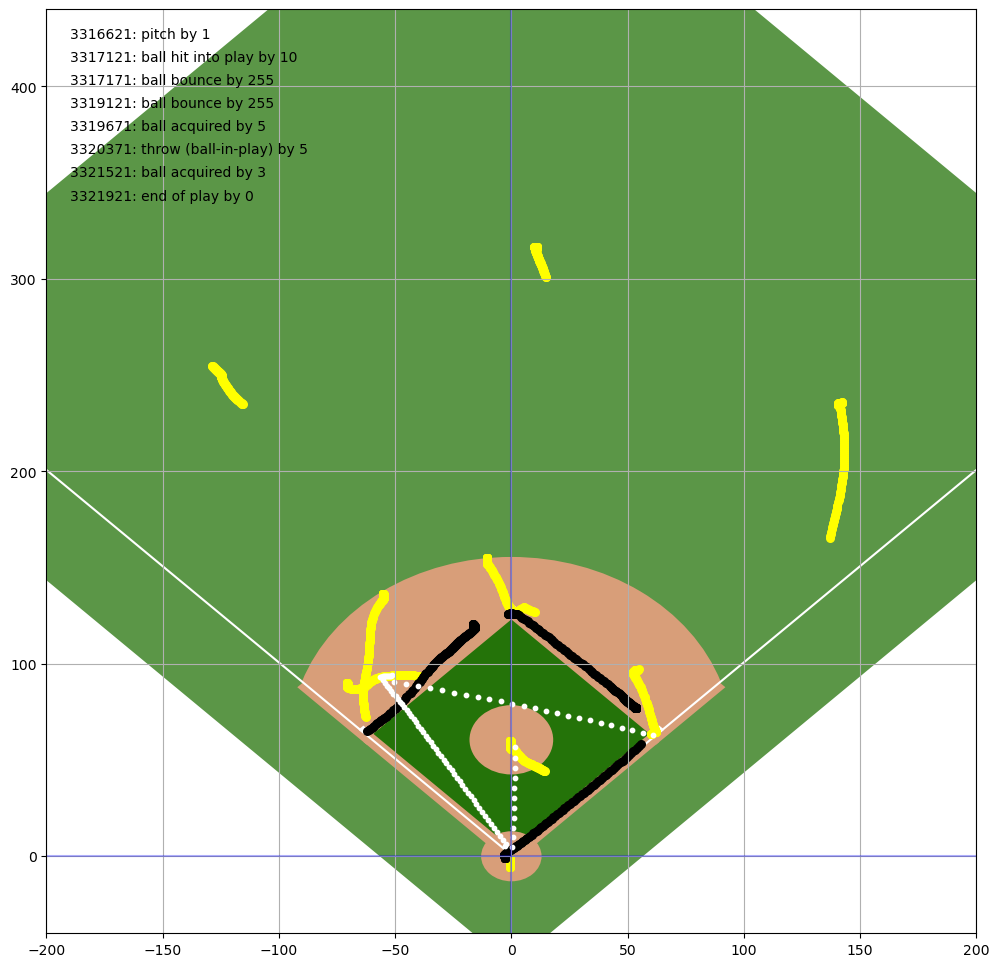

In [14]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(109)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Bottom 3

This is a 1-2-3 inning

In [15]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 3) & (game_info_1903_30["top_bottom_inning"] == "Bottom")]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
109,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,32,110,3,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,2148,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
110,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,32,111,3,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,2148,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
111,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,32,112,3,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,2148,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
112,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,32,113,3,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,2148,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
113,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,32,114,3,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,2148,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1,1,1
114,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,33,115,3,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
115,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,33,116,3,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
116,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,33,117,3,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
117,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,33,118,3,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
118,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,33,119,3,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0,1,1,1,1.0,0.0,0.0,0.0,1,1,1


### Top 4

A 1-2-3 inning

- 122 is a flyout
- 128 is a flyout
- 131 is a flyout

In [16]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 4) & (game_info_1903_30["top_bottom_inning"] == "Top")]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
121,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,35,122,4,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8079,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1,1,0
122,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,36,123,4,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,6789,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,0
123,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,36,124,4,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,6789,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,0
124,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,36,125,4,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,6789,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,0
125,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,37,126,4,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3291,6789,0,0,1,1,0,1,1.0,1.0,0.0,0.0,1,1,0
126,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,37,127,4,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3291,6789,0,0,1,1,0,1,1.0,1.0,0.0,0.0,1,1,0
127,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,37,128,4,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3291,6789,0,0,1,1,1,1,1.0,1.0,0.0,0.0,1,1,0
128,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,38,129,4,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3363,6789,0,0,1,2,0,0,NaN,NaN,NaN,NaN,0,1,0
129,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,38,130,4,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3363,6789,0,0,1,2,0,1,1.0,1.0,0.0,0.0,1,1,0
130,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,38,131,4,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3363,6789,0,0,1,2,1,1,1.0,1.0,0.0,0.0,1,1,0


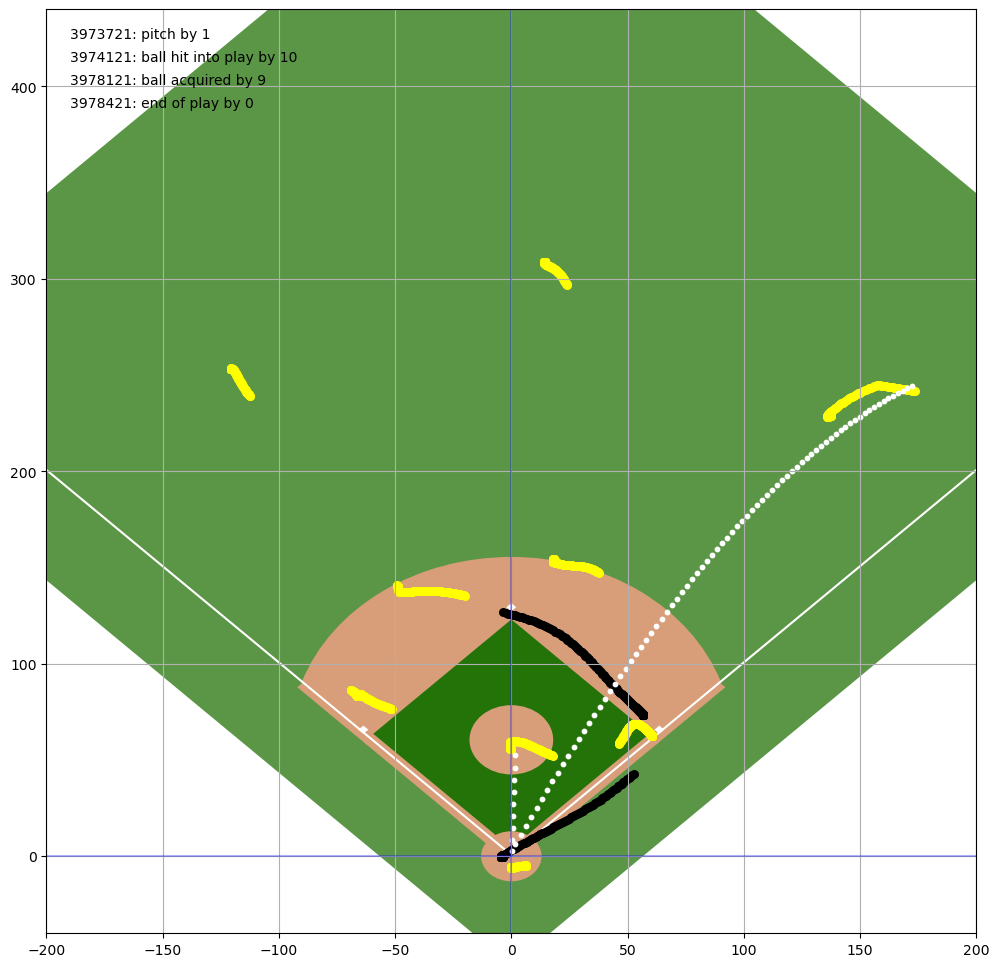

In [17]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(131)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Bottom 4

- 132 is popup to short
- 134 is a flyout
- 137 is a flyout

In [18]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 4) & (game_info_1903_30["top_bottom_inning"] == "Bottom")]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
131,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,39,132,4,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1973,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1,1,1
132,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,40,133,4,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1185,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
133,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,40,134,4,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1185,0,0,0,0,1,1,1,1.0,0.0,0.0,0.0,1,1,1
134,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,41,135,4,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,0,0,0,2,0,1,1.0,0.0,0.0,0.0,1,1,1
135,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,41,136,4,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,0,0,0,2,0,1,1.0,0.0,0.0,0.0,1,1,1
136,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,42,137,4,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,2386,1945,0,0,1,2,1,1,1.0,1.0,0.0,0.0,1,1,1


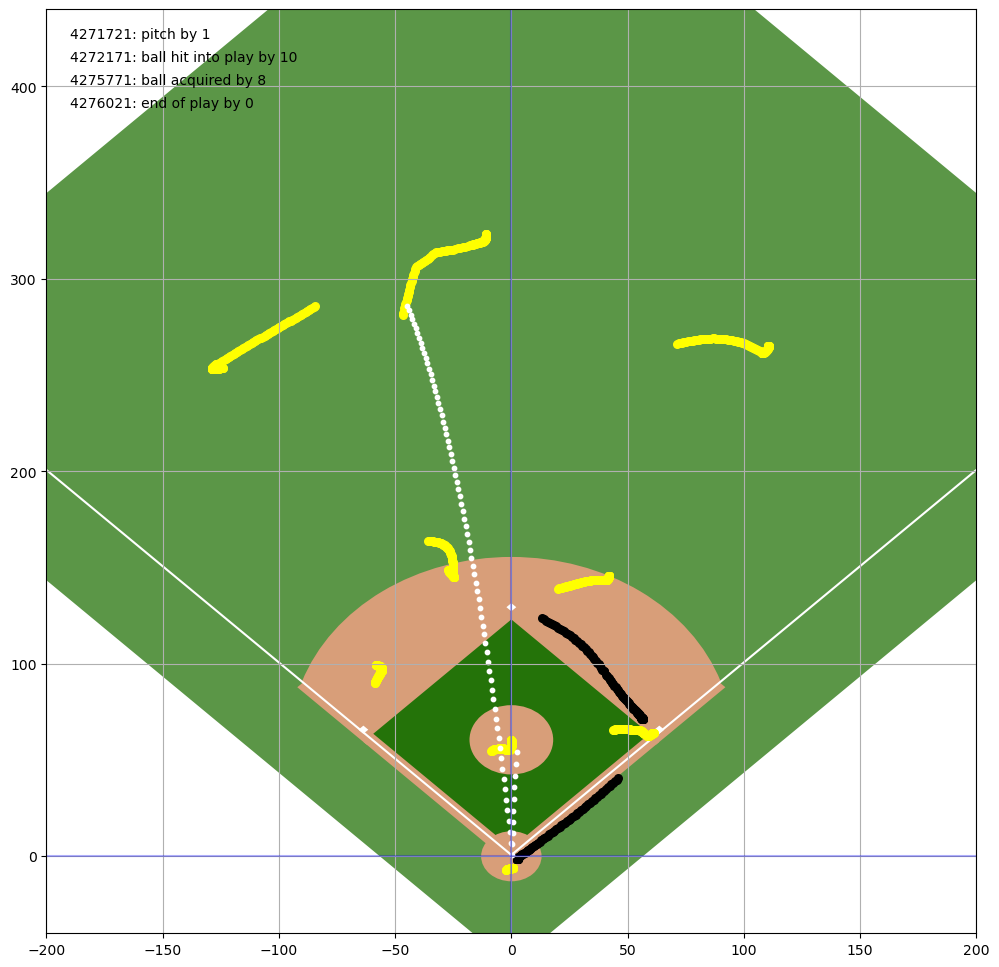

In [19]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(137)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Top 5

In [20]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 5) & (game_info_1903_30["top_bottom_inning"] == "Top")]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
137,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,43,138,5,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1,1,1
138,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,44,139,5,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
139,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,44,140,5,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
140,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,44,141,5,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
141,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,44,142,5,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,0,1,1,1,1.0,0.0,0.0,0.0,1,1,1
142,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,45,143,5,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3718,0,0,0,0,2,0,1,1.0,0.0,0.0,0.0,1,1,1
143,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,45,144,5,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3718,0,0,0,0,2,1,1,1.0,0.0,0.0,0.0,1,1,1


Another 1-2-3

- 138 is 1-3 ground out
- 142 is another 1-3 ground out
- 144 5-3 ground out

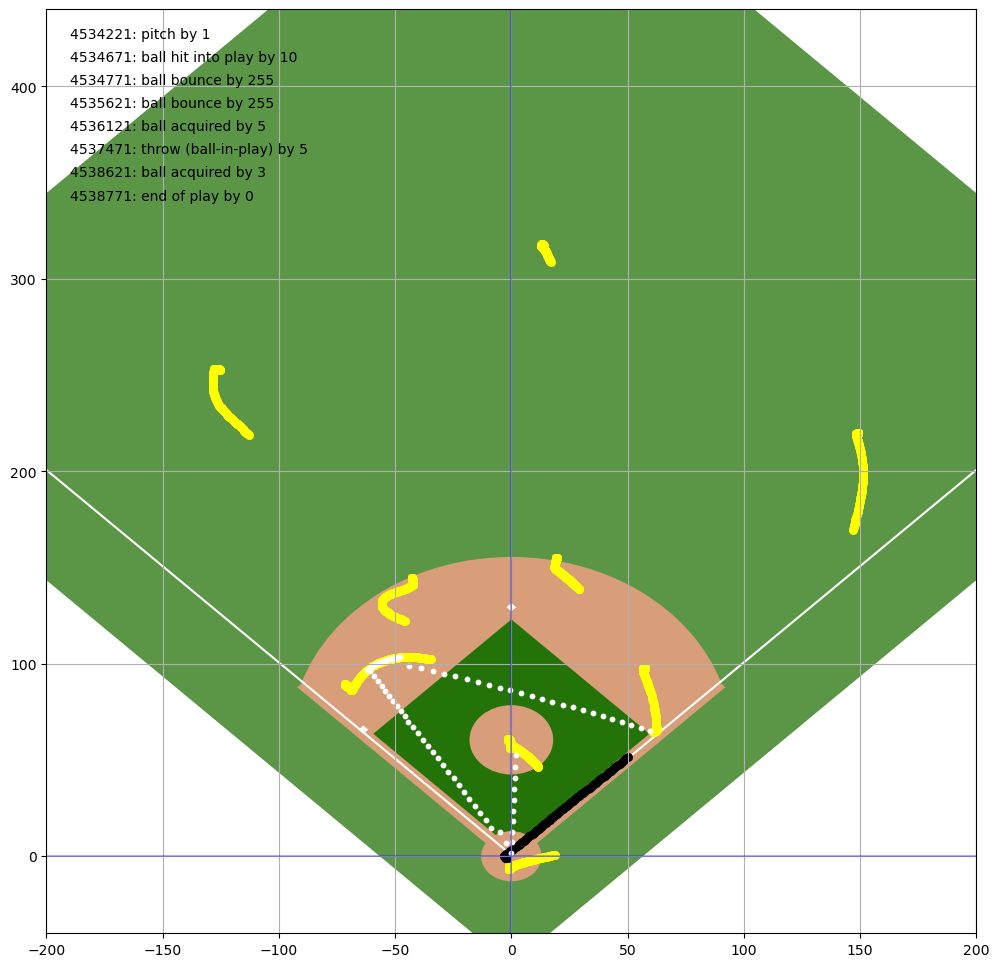

In [21]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(144)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Bottom 5

In [22]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 5) & (game_info_1903_30["top_bottom_inning"] == "Bottom")]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
144,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,46,145,5,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1771,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
145,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,46,146,5,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1771,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
146,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,46,147,5,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1771,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
147,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,47,148,5,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1286,1771,0,0,1,0,0,1,1.0,1.0,0.0,0.0,1,1,1
148,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,47,149,5,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1286,1771,0,0,1,0,0,1,1.0,1.0,0.0,0.0,1,1,1
149,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,47,150,5,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1286,1771,0,0,1,0,0,1,1.0,1.0,0.0,0.0,1,1,1
150,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,47,151,5,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1286,1771,0,0,1,0,0,1,1.0,1.0,0.0,0.0,1,1,1
151,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,47,152,5,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1286,1771,0,0,1,0,0,1,1.0,1.0,0.0,0.0,1,1,1
152,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,48,153,5,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,2148,1286,1771,0,2,0,0,1,1.0,1.0,1.0,0.0,1,1,1
153,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,48,154,5,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,2148,1286,1771,0,2,0,0,1,1.0,1.0,1.0,0.0,1,1,1


#### Where should there be outs:

- 154 could be an out if its a play at the plate -- I think this is not an out
- 159 is a flyout
- 160 is a fielder's choice, where the running beats the throw that would have turned two
- 165 is a 6-4 put out


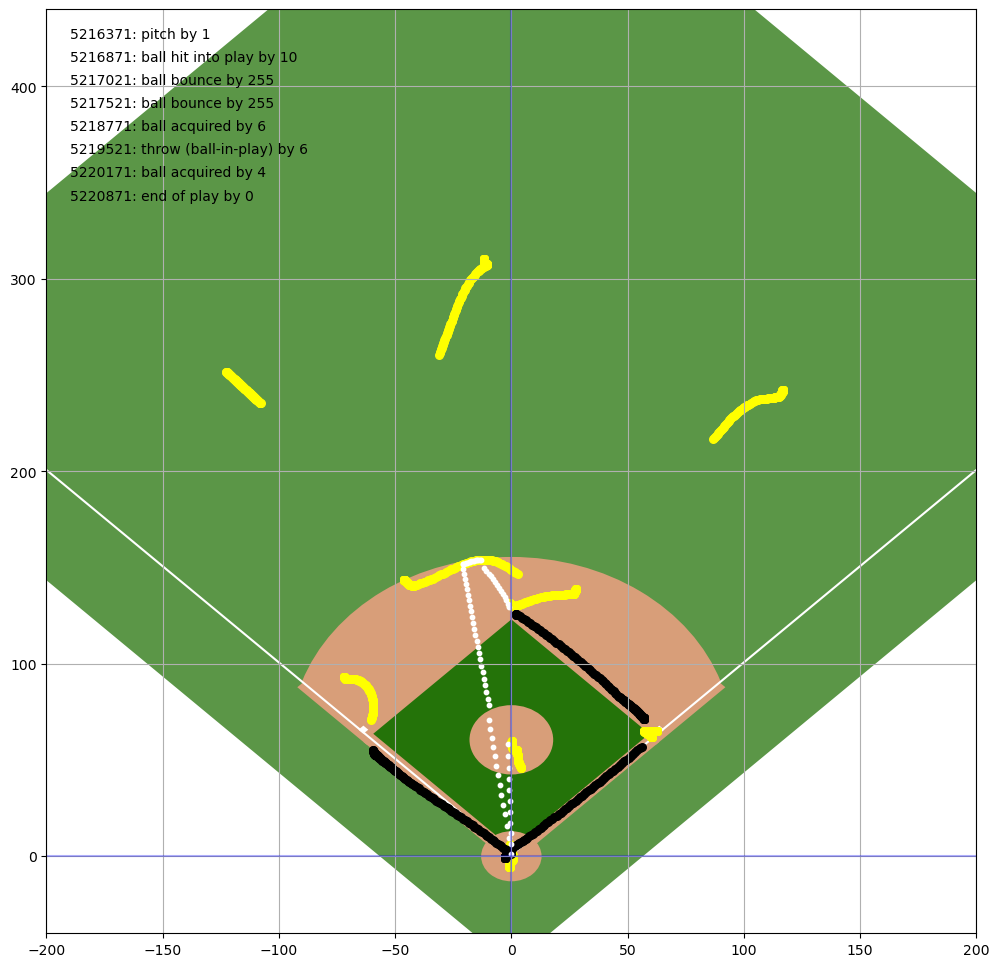

In [23]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(165)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Top 6 -- its says don't trust, but this one is fine

In [24]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 6) & (game_info_1903_30["top_bottom_inning"] == "Top")]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
165,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,52,166,6,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,0
166,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,52,167,6,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,0
167,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,52,168,6,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,0
168,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,52,169,6,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,0
169,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,52,170,6,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,0
170,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,53,171,6,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,4794,5291,0,0,1,0,1,1,1.0,1.0,0.0,0.0,1,1,0
171,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,54,172,6,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8079,5291,0,0,1,1,0,1,1.0,1.0,0.0,0.0,1,1,0
172,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,54,173,6,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8079,5291,0,0,1,1,0,1,1.0,1.0,0.0,0.0,1,1,0
173,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,54,174,6,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8079,5291,0,0,1,1,0,1,1.0,1.0,0.0,0.0,1,1,0
174,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,55,175,6,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,6789,0,8079,5291,2,1,0,1,1.0,0.0,1.0,1.0,1,1,0


#### Where should there be outs:

- 171 is a popup
- 176 is proabably a wild pitch and a score -- lol
- 178 is a RBI sacrifice of some kind (6-3 RBI groundout)
- 182 is a strikeout


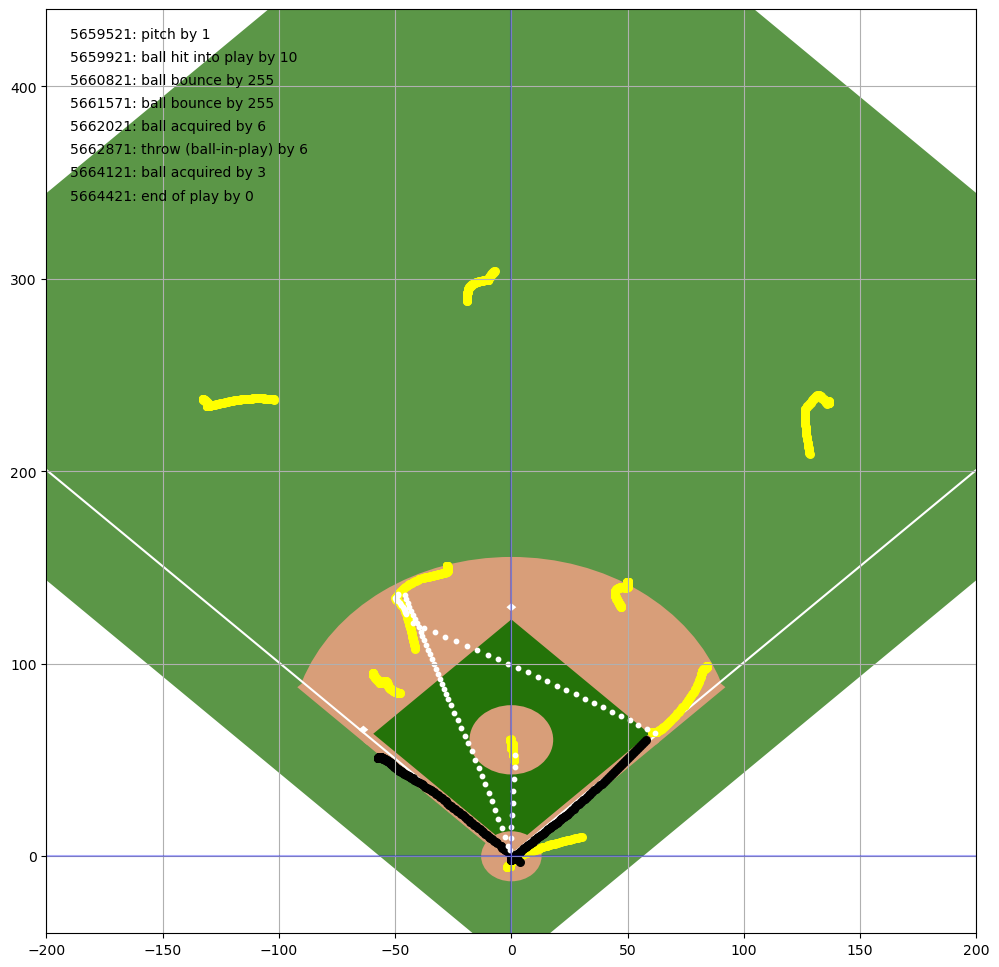

In [25]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(178)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Bottom of 6 -- Something is missing, don't trust this one


In [26]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 6) & (game_info_1903_30["top_bottom_inning"] == "Bottom")]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
182,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,57,183,6,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1185,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,0
183,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,58,184,6,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1945,1185,0,0,1,0,0,0,NaN,NaN,NaN,NaN,0,1,0
184,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,58,185,6,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1945,1185,0,0,1,0,0,1,1.0,1.0,0.0,0.0,1,1,0
185,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,58,186,6,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1945,1185,0,0,1,0,0,1,1.0,1.0,0.0,0.0,1,1,0
186,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,58,187,6,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1945,1185,0,0,1,0,0,1,1.0,1.0,0.0,0.0,1,1,0
187,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,58,188,6,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,1185,0,1,0,0,1,1.0,0.0,1.0,0.0,1,1,0
188,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,58,189,6,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,1185,0,1,0,0,1,1.0,0.0,1.0,0.0,1,1,0
189,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,58,190,6,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,1185,0,1,0,0,1,1.0,0.0,1.0,0.0,1,1,0
190,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,58,191,6,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,1185,0,1,0,0,1,1.0,0.0,1.0,0.0,1,1,0
191,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,58,192,6,Bottom,7819,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,1185,0,1,0,0,1,1.0,0.0,1.0,0.0,1,1,0


#### Where should there be outs:


- 187 is a steal?

- TODO: Bring this one up!!! 
    - 198 looks just like a pitch catch? but the third br disappears?
    
- 200 is a strikeout
- 202 is just a flyout -- maybe make a new rule for this one? (e.g. fly ball rule!)



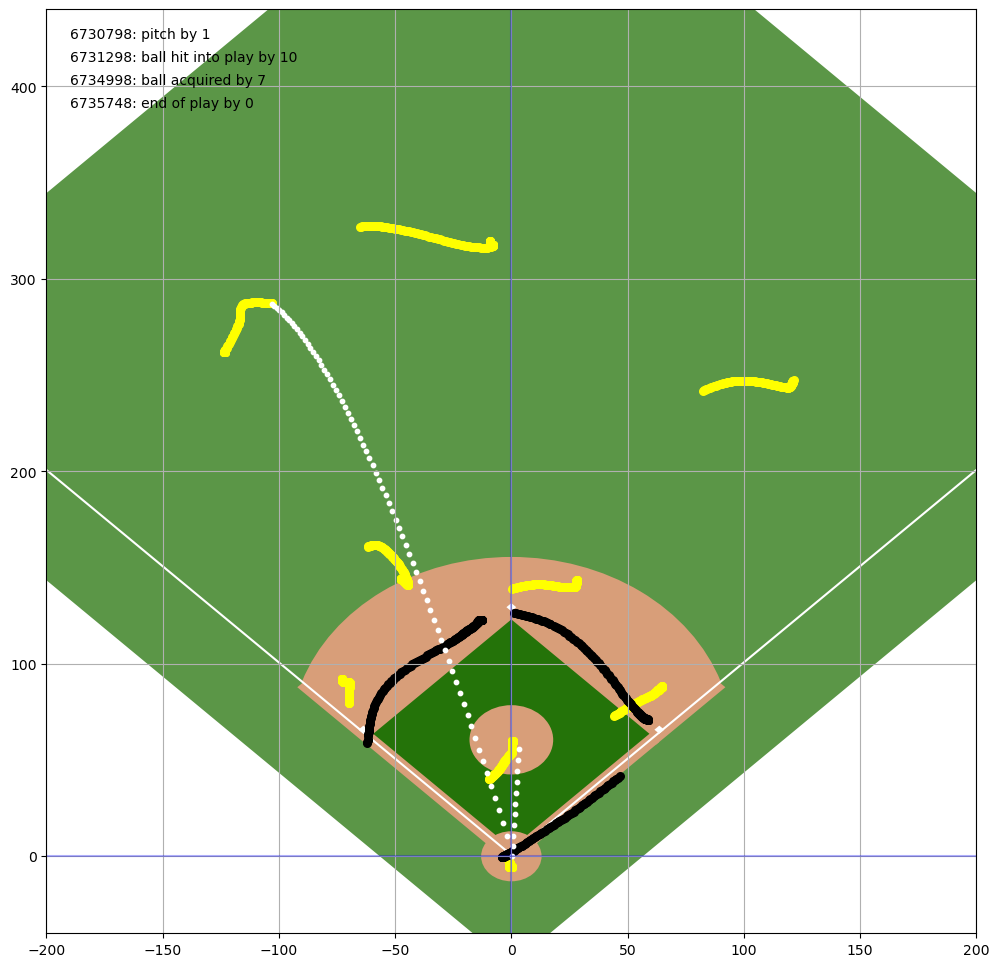

In [27]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(202)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Top 7

In [28]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 7) & (game_info_1903_30["top_bottom_inning"] == "Top")]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
202,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,63,203,7,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,3363,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
203,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,63,204,7,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,3363,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
204,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,63,205,7,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,3363,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
205,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,63,206,7,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,3363,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1,1,1
206,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,64,207,7,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
207,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,64,208,7,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
208,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,64,209,7,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
209,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,64,210,7,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
210,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,64,211,7,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0,1,1,1,1.0,0.0,0.0,0.0,1,1,1
211,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,65,212,7,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,0,2,0,1,1.0,0.0,0.0,0.0,1,1,1


#### This is a 1-2-3 inning
- 206 is dropped third 2-3 putout
- 211 is a popup to 5
- 215 must be a strikeout


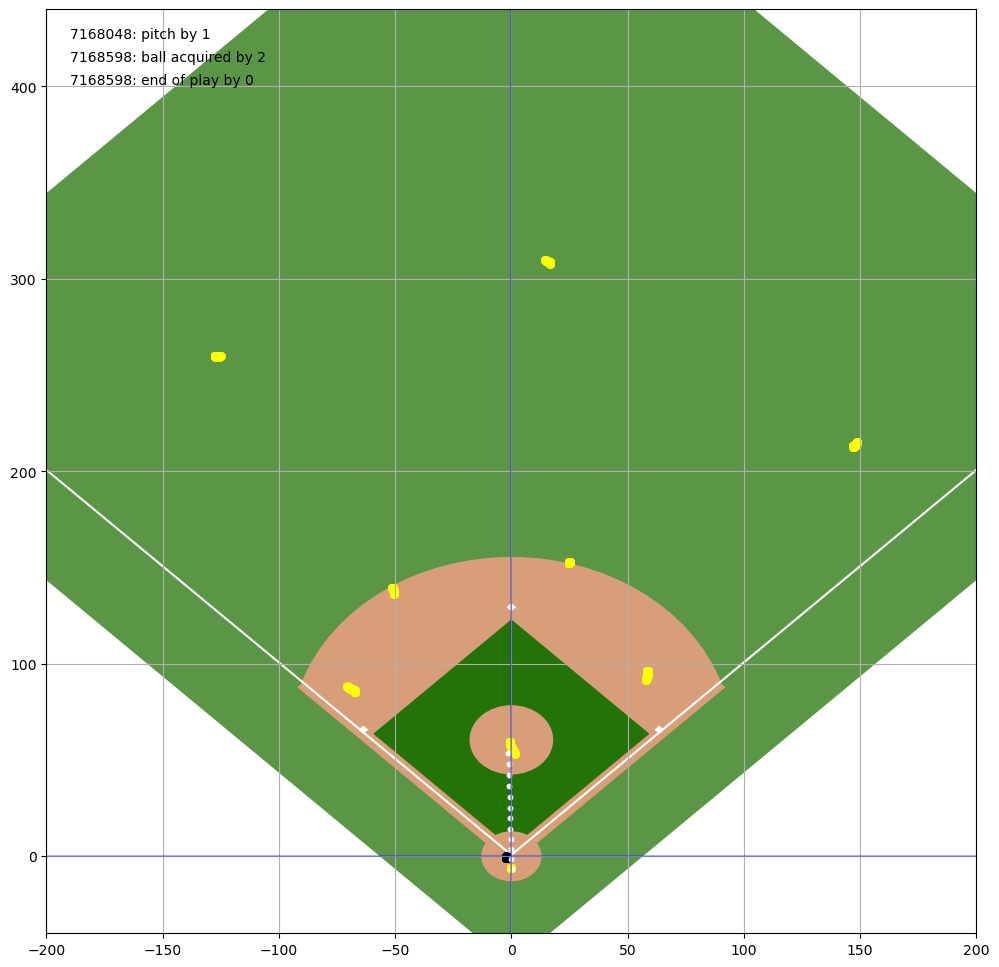

In [29]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(215)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Bottom 7

In [30]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 7) & (game_info_1903_30["top_bottom_inning"] == "Bottom")]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
215,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,66,216,7,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
216,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,66,217,7,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
217,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,66,218,7,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
218,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,66,219,7,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1,1,1
219,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,67,220,7,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,2766,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
220,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,67,221,7,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,2766,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
221,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,67,222,7,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,2766,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
222,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,67,223,7,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,2766,0,0,0,0,1,1,1,1.0,0.0,0.0,0.0,1,1,1
223,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,68,224,7,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,1973,0,0,0,0,2,0,1,1.0,0.0,0.0,0.0,1,1,1
224,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,68,225,7,Bottom,5565,3718,6789,6189,3363,8079,8638,5291,3291,1973,0,0,0,0,2,0,1,1.0,0.0,0.0,0.0,1,1,1


#### This is a 1-2-3 inning

- 219 a 5-3 putout
- 223 a strikeout
- 227 a 4-3 putout

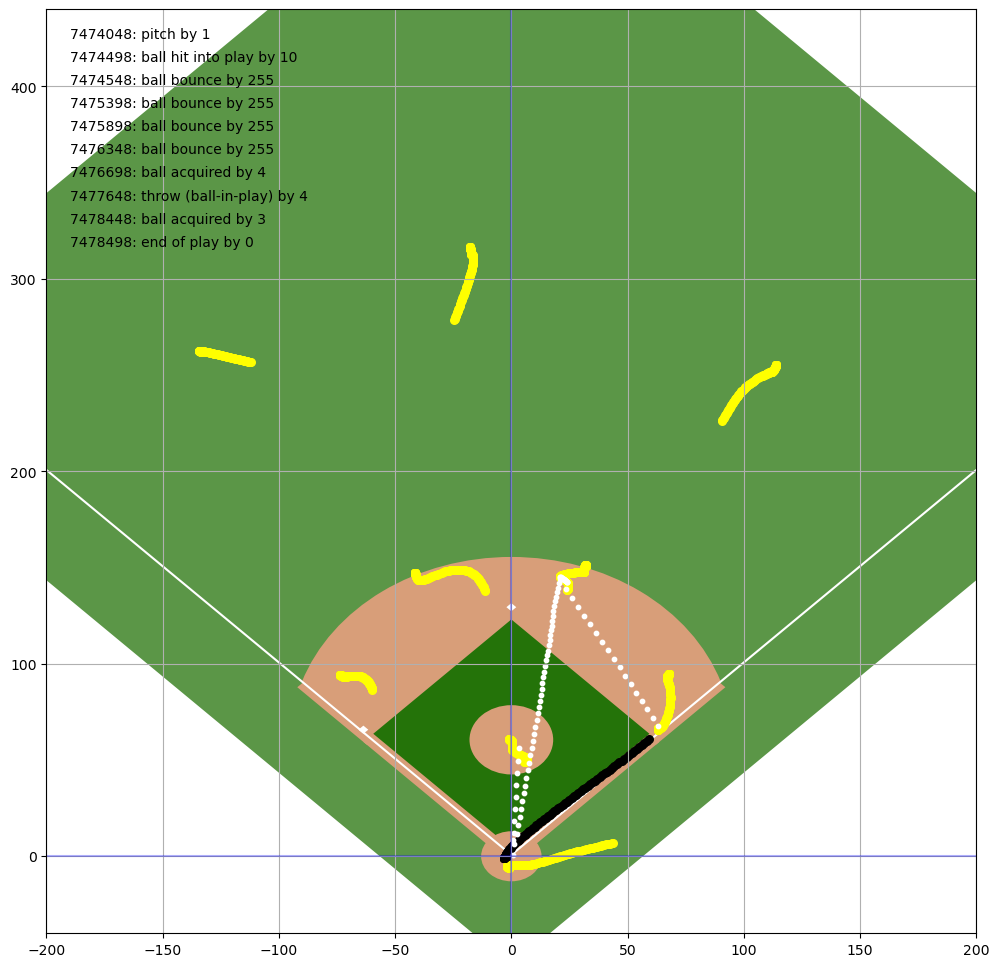

In [31]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(227)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Top of 8 works now

In [32]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 8) & (game_info_1903_30["top_bottom_inning"] == "Top")]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
227,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,69,228,8,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,3718,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
228,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,69,229,8,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,3718,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
229,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,69,230,8,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,3718,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
230,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,70,231,8,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,5291,3718,0,0,1,0,0,1,1.0,1.0,0.0,0.0,1,1,1
231,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,70,232,8,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,5291,3718,0,0,1,0,0,1,1.0,1.0,0.0,0.0,1,1,1
232,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,70,233,8,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,5291,3718,0,0,1,0,0,1,1.0,1.0,0.0,0.0,1,1,1
233,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,70,234,8,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,5291,3718,0,0,1,0,1,1,1.0,1.0,0.0,0.0,1,1,1
234,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,71,235,8,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,4794,0,3718,0,1,1,0,1,1.0,0.0,1.0,0.0,1,1,1
235,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,71,236,8,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,4794,0,3718,0,1,1,0,1,1.0,0.0,1.0,0.0,1,1,1
236,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,72,237,8,Top,1250,1945,1286,2919,1771,2148,1973,2766,1185,8079,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1


#### Where should there be outs:

- 234 is 4-3, runner advances
- 236 should be HR
- 249 is a strikeout
- 256 must be another strikeout



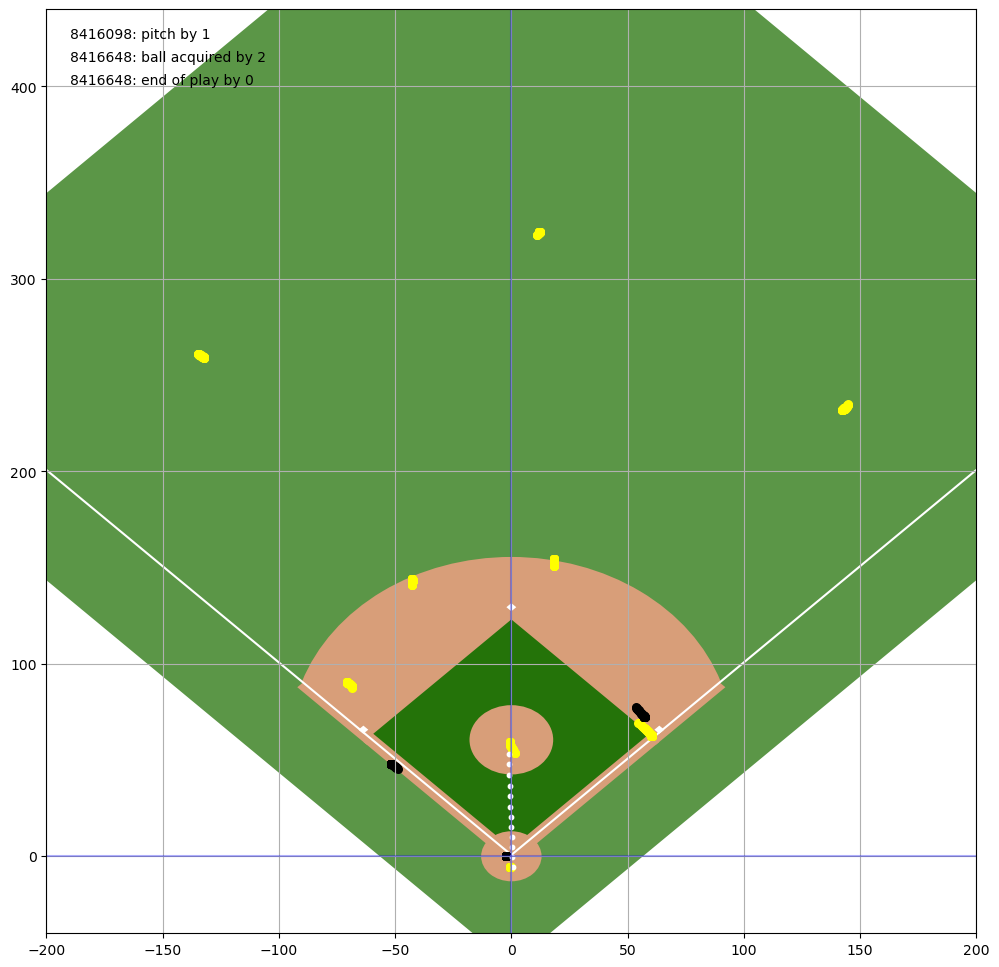

In [33]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(256)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--lazy fly to left")


### Bottom 8

In [34]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 8) & (game_info_1903_30["top_bottom_inning"] == "Bottom")]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
256,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,76,257,8,Bottom,4934,3718,6789,6189,3363,8079,8638,5291,3291,1185,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
257,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,76,258,8,Bottom,4934,3718,6789,6189,3363,8079,8638,5291,3291,1185,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
258,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,76,259,8,Bottom,4934,3718,6789,6189,3363,8079,8638,5291,3291,1185,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
259,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,76,260,8,Bottom,4934,3718,6789,6189,3363,8079,8638,5291,3291,1185,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1,1,1
260,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,77,261,8,Bottom,4934,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
261,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,77,262,8,Bottom,4934,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
262,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,77,263,8,Bottom,4934,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,0,0,0,1,1,1,1.0,0.0,0.0,0.0,1,1,1
263,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,78,264,8,Bottom,4934,3718,6789,6189,3363,8079,8638,5291,3291,2386,0,0,0,0,2,0,1,1.0,0.0,0.0,0.0,1,1,1
264,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,78,265,8,Bottom,4934,3718,6789,6189,3363,8079,8638,5291,3291,2386,0,0,0,0,2,0,1,1.0,0.0,0.0,0.0,1,1,1
265,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,78,266,8,Bottom,4934,3718,6789,6189,3363,8079,8638,5291,3291,2386,0,0,0,0,2,0,1,1.0,0.0,0.0,0.0,1,1,1


#### A 1-2-3 inning

- 260 a bobble, 4-3 putout
- 263 flyout to 9
- 267 strikout

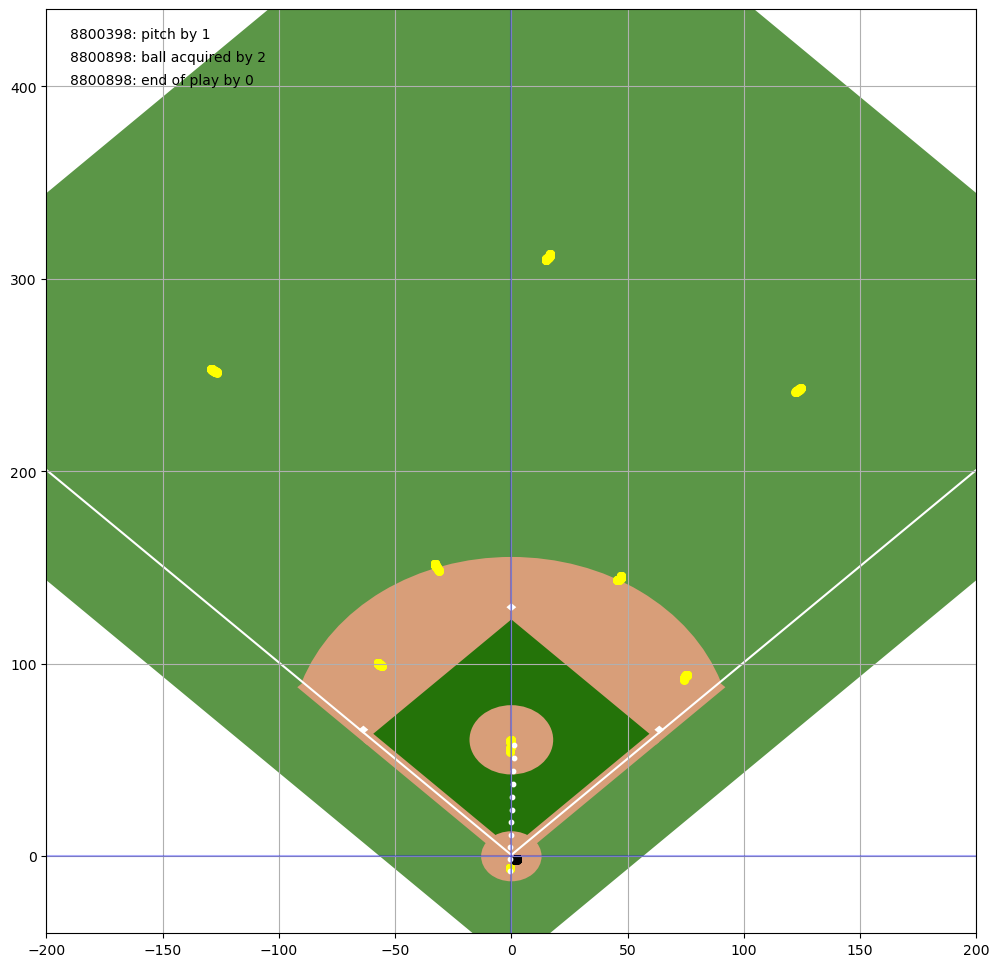

In [35]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(267)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--lazy fly to left")


### Top 9

In [36]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 9) & (game_info_1903_30["top_bottom_inning"] == "Top")]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
267,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,79,268,9,Top,2990,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
268,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,79,269,9,Top,2990,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
269,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,79,270,9,Top,2990,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
270,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,79,271,9,Top,2990,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1,1,1
271,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,80,272,9,Top,2990,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
272,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,80,273,9,Top,2990,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
273,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,80,274,9,Top,2990,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
274,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,80,275,9,Top,2990,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,0,1,1,1,1.0,0.0,0.0,0.0,1,1,1
275,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,81,276,9,Top,2990,1945,1286,2919,1771,2148,1973,2766,1185,3718,0,0,0,0,2,1,1,1.0,0.0,0.0,0.0,1,1,1


#### A 1-2-3 inning

- 271 a 5-3 putout
- 275 flyout to 8
- 276 a 4-3 putout

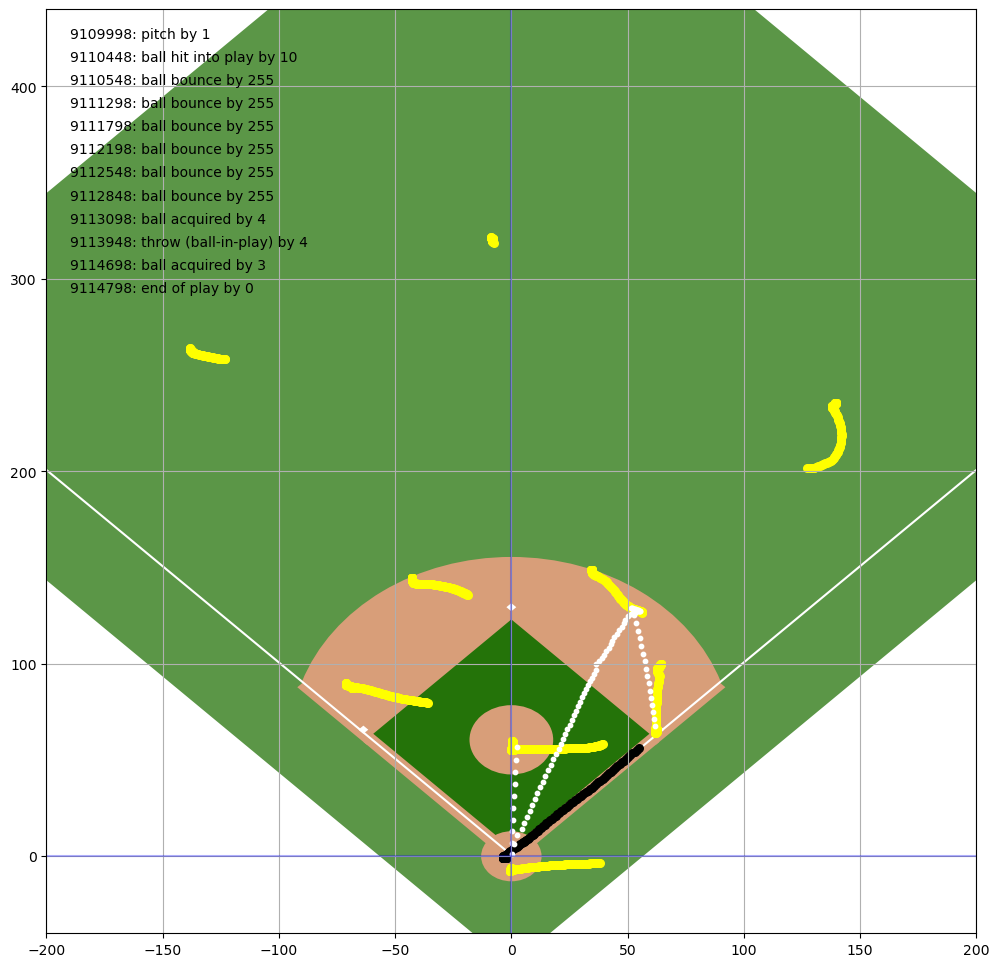

In [37]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(276)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--lazy fly to left")


## Gut Checks



In [38]:
# there should never be more than 3 outs in either column
game_info_1903_30[["prev_outs", "this_play_outs"]].describe()

,prev_outs,this_play_outs
count,276.000000,276.000000
mean,0.894928,0.184783
std,0.822309,0.388826
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,0.000000
max,2.000000,1.000000


### Are all of the things that have two outs obvious double plays?

In [39]:
game_info_1903_30.loc[game_info_1903_30["this_play_outs"] == 2, :]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half


### OTHER CHECKS HERE?





## Try again for a different game: 

In [40]:
bf_1900_01 = Baseball_Field("1900_01_TeamKJ_TeamB")
game_info_1900_01 = bf_1900_01.game_obj.game_info_df.copy()

In [41]:
game_info_1900_01.loc[(game_info_1900_01["inning"] == 1) & (game_info_1900_01["top_bottom_inning"] == "Top")]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
0,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,2,1,Top,1571,2456,2196,1201,2653,2614,2488,2061,2279,8180,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,0
1,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,3,1,Top,1571,2456,2196,1201,2653,2614,2488,2061,2279,8180,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,0
2,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,4,1,Top,1571,2456,2196,1201,2653,2614,2488,2061,2279,8180,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1,1,0
3,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,5,1,Top,1571,2456,2196,1201,2653,2614,2488,2061,2279,6752,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,0
4,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,6,1,Top,1571,2456,2196,1201,2653,2614,2488,2061,2279,6752,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,0
5,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,7,1,Top,1571,2456,2196,1201,2653,2614,2488,2061,2279,6752,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,0
6,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,8,1,Top,1571,2456,2196,1201,2653,2614,2488,2061,2279,7225,6752,0,0,1,1,0,1,1.0,1.0,0.0,0.0,1,1,0
7,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,10,1,Top,1571,2456,2196,1201,2653,2614,2488,2061,2279,7225,6752,0,0,1,1,0,1,1.0,1.0,0.0,0.0,1,1,0
8,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,11,1,Top,1571,2456,2196,1201,2653,2614,2488,2061,2279,7225,6752,0,0,1,1,0,1,1.0,1.0,0.0,0.0,1,1,0
9,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,13,1,Top,1571,2456,2196,1201,2653,2614,2488,2061,2279,7225,6752,0,0,1,1,0,0,1.0,0.0,0.0,0.0,0,1,0


In [42]:
game_info_1900_01.loc[(game_info_1900_01["this_play_outs"] == 1) & (game_info_1900_01["trust_this_half"] == 1)]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
77,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,87,4,Top,1571,2456,2196,1201,2653,2614,2982,2061,2279,7225,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1,1,1
83,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,93,4,Top,1571,2456,2196,1201,2653,2614,2982,2061,2279,6717,0,0,0,0,1,1,1,1.0,0.0,0.0,0.0,1,1,1
86,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,96,4,Top,1571,2456,2196,1201,2653,2614,2982,2061,2279,9218,0,0,0,0,2,1,1,1.0,0.0,0.0,0.0,1,1,1
90,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,100,4,Bottom,8953,9570,9218,8180,6717,6752,8901,5535,7225,2281,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1,1,1
94,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,104,4,Bottom,8953,9570,9218,8180,6717,6752,8901,5535,7225,2488,0,0,0,0,1,1,1,1.0,0.0,0.0,0.0,1,1,1
97,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,107,4,Bottom,8953,9570,9218,8180,6717,6752,8901,5535,7225,2456,0,0,0,0,2,1,1,1.0,0.0,0.0,0.0,1,1,1
175,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,192,7,Top,1571,2456,2196,1201,2653,2614,2982,2061,2279,3137,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1,1,1
181,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,198,7,Top,1571,2456,2196,1201,2653,2614,2982,2061,2279,8901,0,0,0,0,1,1,1,1.0,0.0,0.0,0.0,1,1,1
185,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,202,7,Top,1571,2456,2196,1201,2653,2614,2982,2061,2279,9570,0,0,0,0,2,1,1,1.0,0.0,0.0,0.0,1,1,1
218,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,236,8,Bottom,8133,9570,9218,8180,6717,6752,8901,5535,7225,1201,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1,1,1


#### Where I am confident there are outs
- 93 is a 2-3 putout
- 96 is a strikeout
- 100 flyout to 8
- 104 strikeout?
- 107 strikeout?
- 192 strikeout
- 198 strikeout
- 202 strikeout
- 236 strikeout
- 239 strikeout
- 243 6-3 putout
- 249 strikeout
- 255 strikeout
- 256 IDK on this out? maybe a tip into the glove?

#### Where I am less sure, but there might be outs there are outs

- 4
- 64
- 78 flyout
- 82
- 85
- 111 flyout
- 125
- 127
- 129
- 133
- 142
- 145
- 155
- 160
- 174
- 182
- 189
- 206
- 210
- 216
- 222
- 258
- 264 flyout
- 267
- 268
- 269
- 270 popout to second

In [43]:
game_info_1900_01.loc[(game_info_1900_01["this_play_outs"] == 1) & (game_info_1900_01["valid_half"] == 1) & (game_info_1900_01["trust_this_half"] == 0) ]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
2,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,4,1,Top,1571,2456,2196,1201,2653,2614,2488,2061,2279,8180,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1,1,0
58,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,64,3,Top,1571,2456,2196,1201,2653,2614,2982,2061,2279,5535,1,0,0,0,0,1,0,1.0,1.0,0.0,0.0,0,1,0
68,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,78,3,Bottom,8953,9570,9218,8180,6717,6752,8901,5535,7225,2982,0,2614,0,1,0,1,0,1.0,0.0,0.0,0.0,0,1,0
72,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,82,3,Bottom,8953,9570,9218,8180,6717,6752,8901,5535,7225,2196,0,0,2614,1,1,1,0,1.0,0.0,0.0,0.0,0,1,0
75,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,85,3,Bottom,8953,9570,9218,8180,6717,6752,8901,5535,7225,2653,0,0,0,0,2,1,1,1.0,0.0,0.0,0.0,1,1,0
101,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,111,5,Top,1571,2456,2196,1201,2653,2614,2982,2061,2279,3137,1,0,1,0,0,1,0,1.0,1.0,0.0,1.0,0,1,0
114,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,125,5,Top,1571,2456,2196,1201,2653,2614,2982,2061,2279,8180,0,0,5535,1,1,1,0,1.0,0.0,0.0,0.0,0,1,0
116,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,127,5,Top,1571,2456,2196,1201,2653,2614,2982,2061,2279,6752,0,0,5535,1,2,1,0,1.0,0.0,0.0,0.0,0,1,0
118,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,129,5,Bottom,8953,9570,9218,8180,6717,6752,8901,5535,7225,2061,1,0,0,0,0,1,0,1.0,1.0,0.0,0.0,0,1,0
121,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,133,5,Bottom,8953,9570,9218,8180,6717,6752,8901,5535,7225,1201,0,0,0,0,1,1,1,1.0,0.0,0.0,0.0,1,1,0


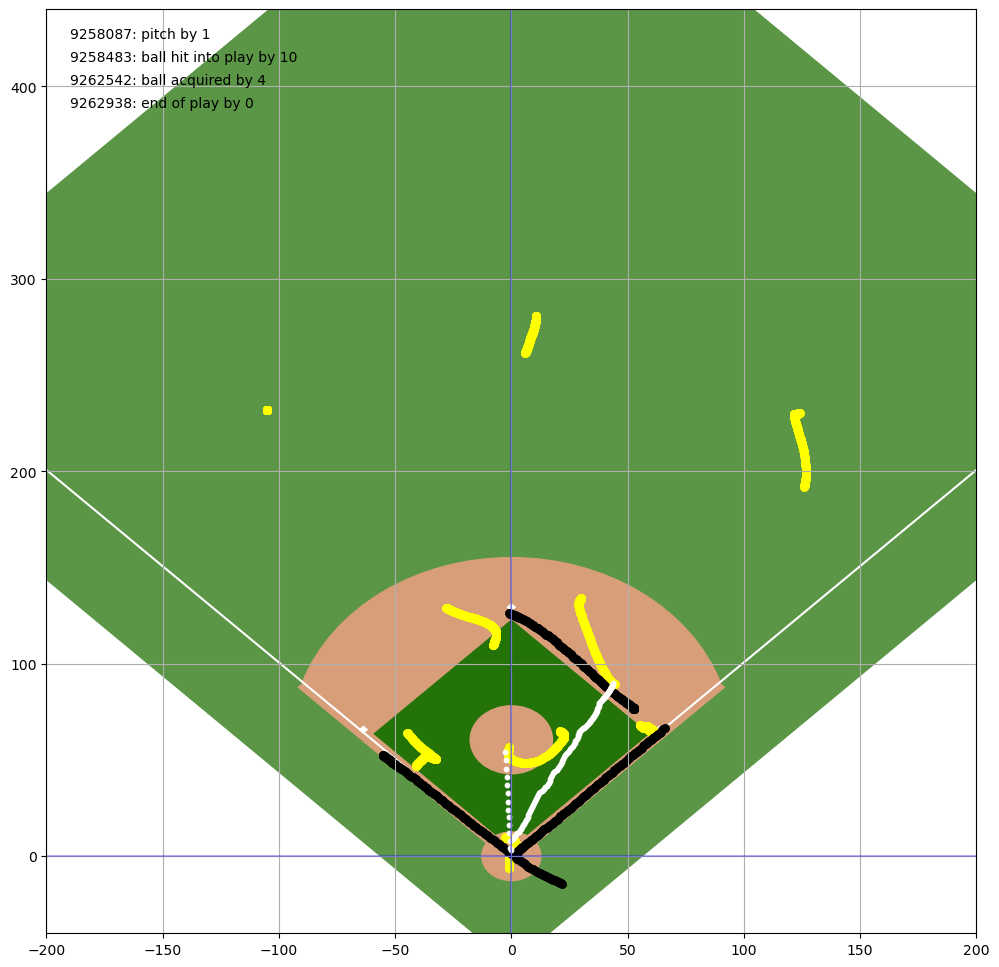

In [44]:
bf_1900_01.clear_plot()

play_id = bf_1900_01.game_obj.get_pid_from_ppg(270)

bf_1900_01.plot_all_components(play_id=play_id)
bf_1900_01.fig

# bf_1900_01.create_gif(play_id=play_id, tag="--lazy fly to left")


In [45]:
bf_1900_01.game_obj.game_events_df.loc[bf_1900_01.game_obj.game_events_df["event"] == "home run"] 

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts
192,1900_01_TeamKJ_TeamB,52,NaN,52,1757410,255,11,home run,5.0,end of play,1758005.0,4.0,ball hit into play,1752361.0


#### Weird missing baserunners in this game 1900_01_TeamKJ_TeamB
- 14, 15, 16 are missing the lead baserunner in game info
- I think there is something weird with the data here! the last play of the top half of the second is a HR
    - its play 52

- This game is all messed up! Idk that I want to deal with this tbh 
- I think just skip these half innings!


In [46]:
game_info_1900_01.loc[(game_info_1900_01["inning"] == 1) & (game_info_1900_01["top_bottom_inning"] == "Bottom")]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
19,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,23,1,Bottom,8953,9570,9218,8180,6717,6752,8901,5535,7225,1201,0,0,0,0,-99,-99,1,1.0,0.0,0.0,0.0,1,1,0
20,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,24,1,Bottom,8953,9570,9218,8180,6717,6752,8901,5535,7225,1201,1,0,0,0,-99,-99,0,1.0,1.0,0.0,0.0,0,1,0
21,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,25,1,Bottom,8953,9570,9218,8180,6717,6752,8901,5535,7225,1201,1,1,0,0,-99,-99,0,1.0,1.0,1.0,0.0,0,1,0
22,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,26,1,Bottom,8953,9570,9218,8180,6717,6752,8901,5535,7225,2614,1201,1,0,1,-99,-99,0,1.0,1.0,1.0,0.0,0,1,0
23,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,27,1,Bottom,8953,9570,9218,8180,6717,6752,8901,5535,7225,2982,2614,1201,1,2,-99,-99,0,1.0,0.0,1.0,1.0,0,1,0
24,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,28,1,Bottom,8953,9570,9218,8180,6717,6752,8901,5535,7225,2982,2614,1201,1,2,-99,-99,0,1.0,0.0,1.0,1.0,0,1,0
25,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,29,1,Bottom,8953,9570,9218,8180,6717,6752,8901,5535,7225,2196,0,2614,1201,2,-99,-99,1,1.0,0.0,1.0,1.0,1,1,0
26,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,30,1,Bottom,8953,9570,9218,8180,6717,6752,8901,5535,7225,2653,0,2614,1201,2,-99,-99,1,1.0,0.0,1.0,1.0,1,1,0
27,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,31,1,Bottom,8953,9570,9218,8180,6717,6752,8901,5535,7225,2653,0,2614,1201,2,-99,-99,1,1.0,0.0,1.0,1.0,1,1,0
28,1900_01_TeamKJ_TeamB,TeamB,TeamKJ,NaN,32,1,Bottom,8953,9570,9218,8180,6717,6752,8901,5535,7225,2653,0,2614,1201,2,-99,-99,1,1.0,0.0,1.0,1.0,1,1,0


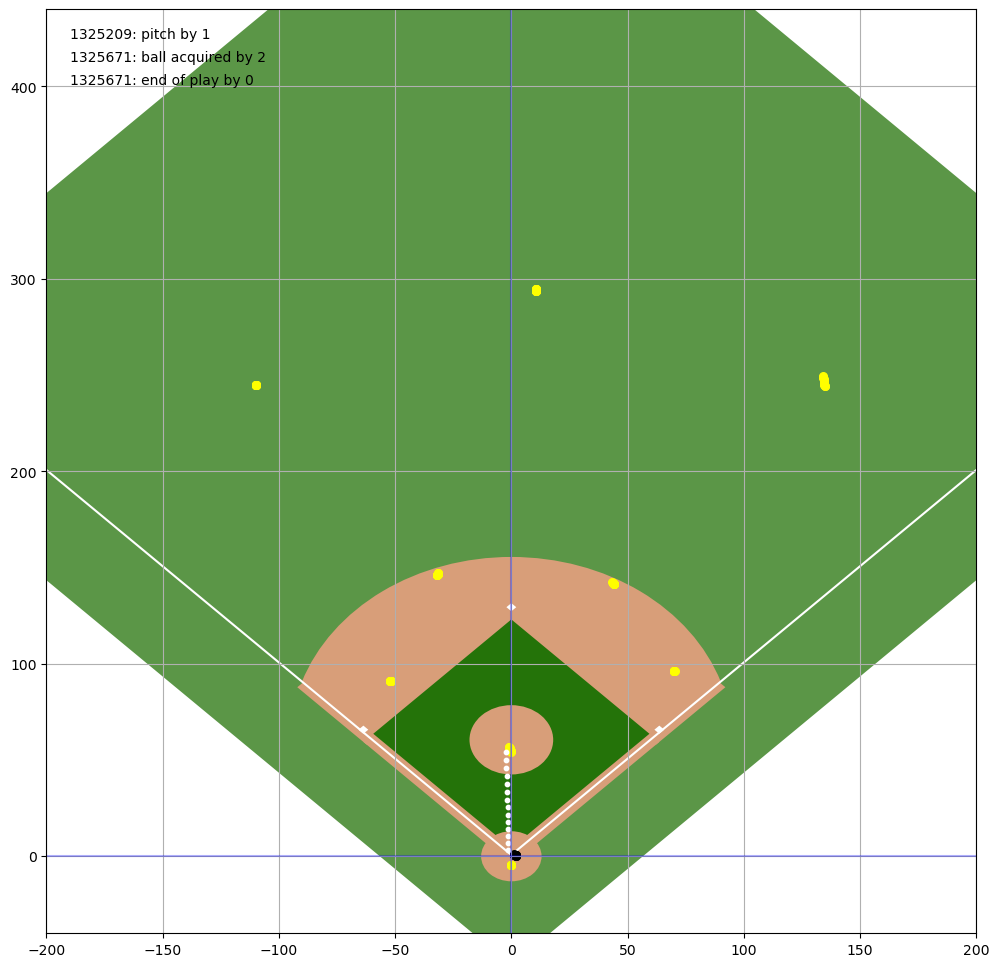

In [47]:
bf_1900_01.clear_plot()

play_id = bf_1900_01.game_obj.get_pid_from_ppg(39)

bf_1900_01.plot_all_components(play_id=play_id)
bf_1900_01.fig

# bf_1900_01.create_gif(play_id=play_id, tag="--7-6-5-1")


## Try a new game! 1903_13_TeamNG_TeamA3

In [48]:
bf_1903_13 = Baseball_Field("1903_13_TeamNG_TeamA3")

game_info_1903_13 = bf_1903_13.game_obj.game_info_df.copy()

In [49]:
game_info_1903_13.loc[(game_info_1903_13["this_play_outs"] >= 1) & (game_info_1903_13["trust_this_half"] == 1)]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
19,1903_13_TeamNG_TeamA3,TeamA3,TeamNG,5,20,1,Bottom,5747,5235,4579,6234,9348,3247,8490,9206,9261,1628,0,0,0,0,0,1,1,1,0,0,0,1,1,1
23,1903_13_TeamNG_TeamA3,TeamA3,TeamNG,6,24,1,Bottom,5747,5235,4579,6234,9348,3247,8490,9206,9261,2737,0,0,0,0,1,1,1,1,0,0,0,1,1,1
32,1903_13_TeamNG_TeamA3,TeamA3,TeamNG,8,33,1,Bottom,5747,5235,4579,6234,9348,3247,8490,9206,9261,1784,2053,0,0,1,2,1,1,1,1,0,0,1,1,1
34,1903_13_TeamNG_TeamA3,TeamA3,TeamNG,9,35,2,Top,2144,2222,2467,2053,1784,1643,1628,2737,1802,8490,0,0,0,0,0,1,1,1,0,0,0,1,1,1
37,1903_13_TeamNG_TeamA3,TeamA3,TeamNG,10,38,2,Top,2144,2222,2467,2053,1784,1643,1628,2737,1802,4579,0,0,0,0,1,1,1,1,0,0,0,1,1,1
42,1903_13_TeamNG_TeamA3,TeamA3,TeamNG,11,43,2,Top,2144,2222,2467,2053,1784,1643,1628,2737,1802,5235,0,0,0,0,2,1,1,1,0,0,0,1,1,1
47,1903_13_TeamNG_TeamA3,TeamA3,TeamNG,12,48,2,Bottom,5747,5235,4579,6234,9348,3247,8490,9206,9261,2467,0,0,0,0,0,1,1,1,0,0,0,1,1,1
48,1903_13_TeamNG_TeamA3,TeamA3,TeamNG,13,49,2,Bottom,5747,5235,4579,6234,9348,3247,8490,9206,9261,1802,0,0,0,0,1,1,1,1,0,0,0,1,1,1
52,1903_13_TeamNG_TeamA3,TeamA3,TeamNG,14,53,2,Bottom,5747,5235,4579,6234,9348,3247,8490,9206,9261,1617,0,0,0,0,2,1,1,1,0,0,0,1,1,1
54,1903_13_TeamNG_TeamA3,TeamA3,TeamNG,15,55,3,Top,2144,2222,2467,2053,1784,1643,1628,2737,1802,6234,0,0,0,0,0,1,1,1,0,0,0,1,1,1


In [50]:
game_info_1903_13.loc[(game_info_1903_13["this_play_outs"] > 1) & (game_info_1903_13["trust_this_half"] == 1)]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
235,1903_13_TeamNG_TeamA3,TeamA3,TeamNG,60,236,9,Top,2322,2222,2467,2053,1784,1643,1628,2737,1802,8490,9261,9348,0,2,1,2,1,1,1,1,0,1,1,1


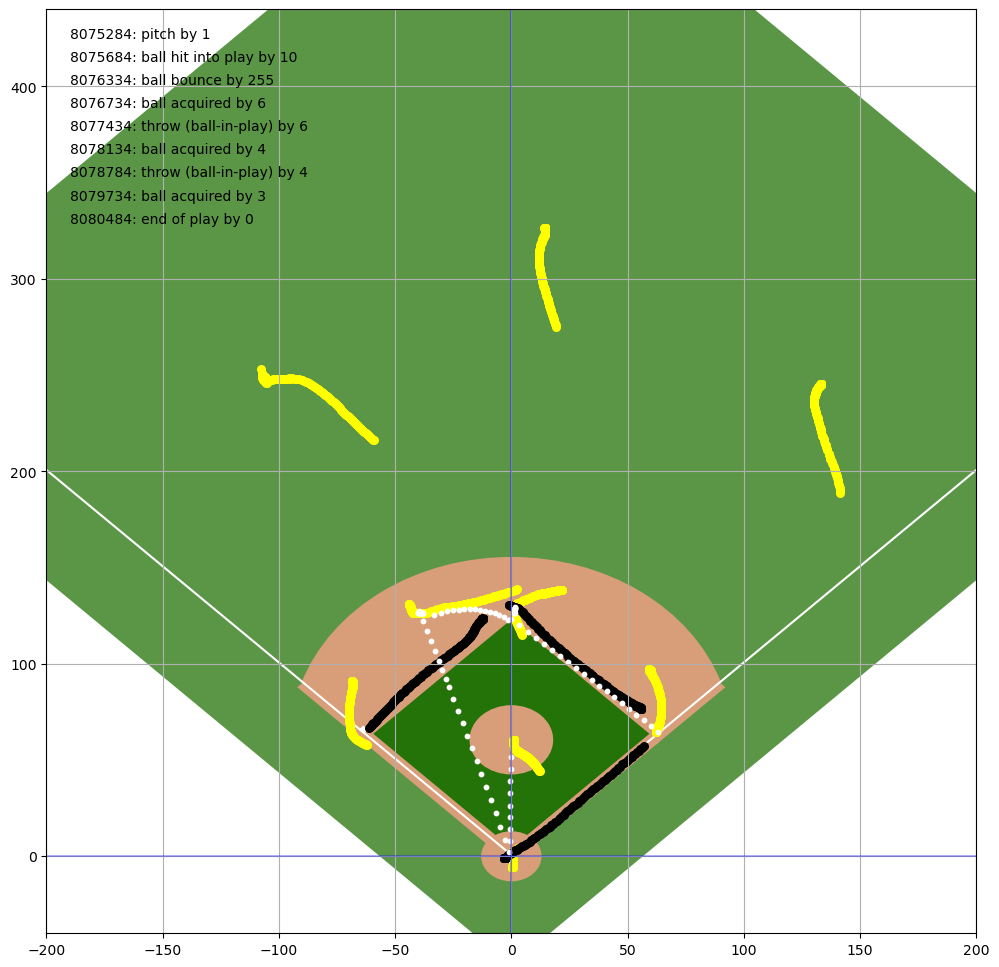

In [51]:

bf_1903_13.clear_plot()

play_id = bf_1903_13.game_obj.get_pid_from_ppg(236)

bf_1903_13.plot_all_components(play_id=play_id)
bf_1903_13.fig


# bf_1903_13.create_gif(play_id=play_id, tag="--6-4-3_DP")


#### I think the whole game for bf_1903_13 works!

## Spot check: 1903_17_TeamNI_TeamA3

In [53]:
bf_1903_17 = Baseball_Field("1903_17_TeamNI_TeamA3")

game_info_1903_17 = bf_1903_17.game_obj.game_info_df.copy()

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:634: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


In [54]:
game_info_1903_17.loc[(game_info_1903_17["this_play_outs"] == 1) & (game_info_1903_17["trust_this_half"] == 1)]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
34,1903_17_TeamNI_TeamA3,TeamA3,TeamNI,10,35,2,Top,2592,2222,2737,1628,1784,2590,2053,1643,1802,3710,0,0,0,0,0,1,1,1,0,0,0,1,1,1
39,1903_17_TeamNI_TeamA3,TeamA3,TeamNI,11,40,2,Top,2592,2222,2737,1628,1784,2590,2053,1643,1802,4704,0,0,0,0,1,1,1,1,0,0,0,1,1,1
42,1903_17_TeamNI_TeamA3,TeamA3,TeamNI,12,43,2,Top,2592,2222,2737,1628,1784,2590,2053,1643,1802,7293,0,0,0,0,2,1,1,1,0,0,0,1,1,1
47,1903_17_TeamNI_TeamA3,TeamA3,TeamNI,13,48,2,Bottom,8908,8557,8020,6697,4704,5849,5865,3542,7293,2737,0,0,0,0,0,1,1,1,0,0,0,1,1,1
57,1903_17_TeamNI_TeamA3,TeamA3,TeamNI,16,58,2,Bottom,8908,8557,8020,6697,4704,5849,5865,3542,7293,2222,1643,1617,0,2,1,1,1,1,1,1,0,1,1,1
58,1903_17_TeamNI_TeamA3,TeamA3,TeamNI,17,59,2,Bottom,8908,8557,8020,6697,4704,5849,5865,3542,7293,1628,1643,1617,0,2,2,1,1,1,1,1,0,1,1,1
62,1903_17_TeamNI_TeamA3,TeamA3,TeamNI,18,63,3,Top,2592,2222,2737,1628,1784,2590,2053,1643,1802,8020,0,0,0,0,0,1,1,1,0,0,0,1,1,1
74,1903_17_TeamNI_TeamA3,TeamA3,TeamNI,21,75,3,Top,2592,2222,2737,1628,1784,2590,2053,1643,1802,3542,6697,5849,0,2,1,1,1,1,1,1,0,1,1,1
75,1903_17_TeamNI_TeamA3,TeamA3,TeamNI,22,76,3,Top,2592,2222,2737,1628,1784,2590,2053,1643,1802,5865,6697,5849,0,2,2,1,1,1,1,1,0,1,1,1
83,1903_17_TeamNI_TeamA3,TeamA3,TeamNI,23,84,3,Bottom,8908,8557,8020,6697,4704,5849,5865,3542,7293,2590,0,0,0,0,0,1,1,1,0,0,0,1,1,1


#### Weird missing baserunners in this game 1903_17_TeamNI_TeamA3
- there are two play_per_game 3s here (I wonder if I just remove, if that goes away?)
- Bottom of 1 is missing some plays for sure!
- Top of 4 is literally 1 play, which messes up the -99 assignment
- there is also some duplicate play_per_games here 187




In [55]:
game_info_1903_17.loc[(game_info_1903_17["this_play_outs"] > 1) & (game_info_1903_17["trust_this_half"] == 1)]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
112,1903_17_TeamNI_TeamA3,TeamA3,TeamNI,34,114,5,Top,2817,2222,2737,1628,1784,2590,2053,1643,1802,8020,7293,0,0,1,0,2,1,1,1,0,0,1,1,1
171,1903_17_TeamNI_TeamA3,TeamA3,TeamNI,51,173,6,Bottom,8364,8557,8020,6697,4704,5849,5865,3542,7293,1628,0,0,1617,1,1,2,1,1,0,0,1,1,1,1


#### Ugh there must be missing plays in the sequence because 173 is clearly not a DP

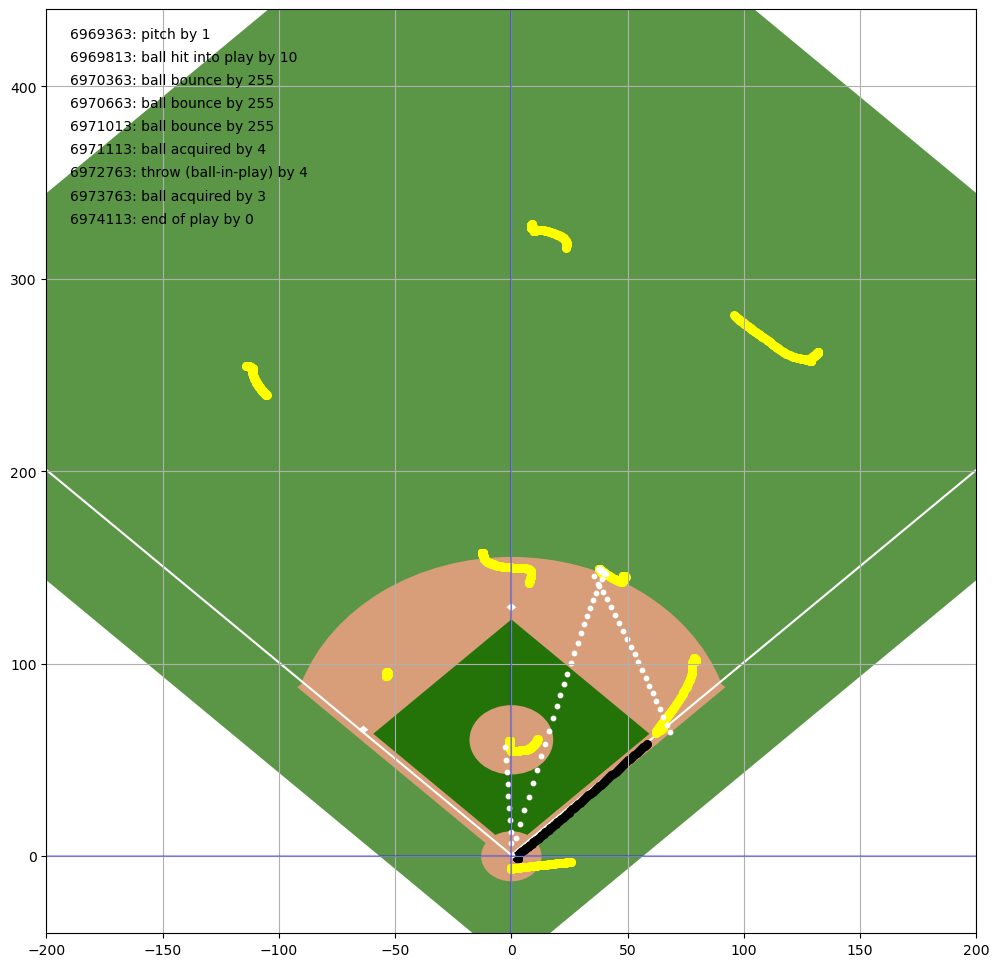

In [56]:

bf_1903_17.clear_plot()

play_id = bf_1903_17.game_obj.get_pid_from_ppg(193)

bf_1903_17.plot_all_components(play_id=play_id)
bf_1903_17.fig


# bf_1903_17.create_gif(play_id=play_id, tag="--2-3 bunt")


#### A curiousity for later -- throws to first where the batter is safe?

In [58]:
g_1903_17_events = bf_1903_17.game_obj.game_events_df.copy()

g_1903_17_events.loc[(g_1903_17_events["event"] == "ball acquired") & (g_1903_17_events["player_position"] == 3) &\
                     (g_1903_17_events["prev_event"] != "pickoff throw") &\
                     g_1903_17_events["play_per_game"].isin(game_info_1903_17.loc[game_info_1903_17["this_play_outs"] == 0, "play_per_game"].values)
                     ,
                     :
                    ]

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts
672,1903_17_TeamNI_TeamA3,164,49,164,5910413,3,2,ball acquired,5.0,end of play,5910713.0,3.0,throw (ball-in-play),5908563.0


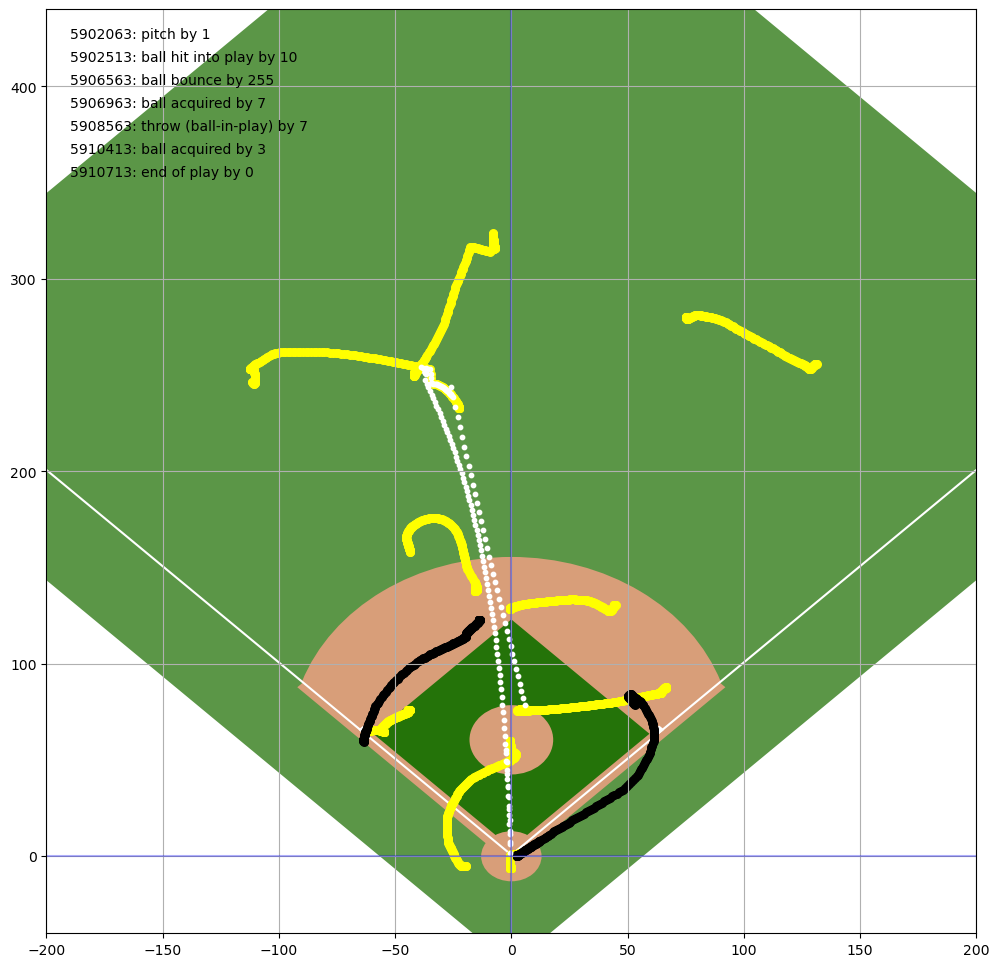

In [59]:
bf_1903_17.clear_plot()

play_id = bf_1903_17.game_obj.get_pid_from_ppg(164)

bf_1903_17.plot_all_components(play_id=play_id)
bf_1903_17.fig

## Spot check: 1902_24_TeamMA_TeamA1

In [60]:
bf_1902_24 = Baseball_Field("1902_24_TeamMA_TeamA1")

In [61]:
game_info_1902_24 = bf_1902_24.game_obj.game_info_df.copy()

In [62]:
game_info_1902_24.loc[(game_info_1902_24["this_play_outs"] > 0) & (game_info_1902_24["trust_this_half"] == 1), :]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
4,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,2.0,5,1,Top,2302,1389,2480,2137,1771,1181,1600,1177,2973,6057,7038,0,0,1,0,1,1,1,1,0,0,1,1,1
9,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,3.0,10,1,Top,2302,1389,2480,2137,1771,1181,1600,1177,2973,3041,0,7038,0,1,1,1,1,1,0,1,0,1,1,1
13,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,4.0,14,1,Top,2302,1389,2480,2137,1771,1181,1600,1177,2973,7415,0,7038,0,1,2,1,1,1,0,1,0,1,1,1
18,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,5.0,19,1,Bottom,5706,7686,3041,3495,9258,6057,3458,7038,9792,1181,0,0,0,0,0,1,1,1,0,0,0,1,1,1
26,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,6.0,27,1,Bottom,5706,7686,3041,3495,9258,6057,3458,7038,9792,1297,0,0,0,0,1,1,1,1,0,0,0,1,1,1
35,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,8.0,36,1,Bottom,5706,7686,3041,3495,9258,6057,3458,7038,9792,1771,0,2973,0,1,2,1,1,1,0,1,0,1,1,1
36,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,9.0,37,2,Top,2302,1389,2480,2137,1771,1181,1600,1177,2973,3458,0,0,0,0,0,1,1,1,0,0,0,1,1,1
40,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,10.0,41,2,Top,2302,1389,2480,2137,1771,1181,1600,1177,2973,9792,0,0,0,0,1,1,1,1,0,0,0,1,1,1
49,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,13.0,50,2,Top,2302,1389,2480,2137,1771,1181,1600,1177,2973,9258,0,7686,0,1,2,1,1,1,0,1,0,1,1,1
57,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,14.0,58,2,Bottom,5706,7686,3041,3495,9258,6057,3458,7038,9792,1600,0,0,0,0,0,1,1,1,0,0,0,1,1,1


In [86]:
this_half_df = game_info_1902_24.loc[(game_info_1902_24["inning"] == 7) & (game_info_1902_24["top_bottom_inning"] == "Bottom"), :]
this_half_df

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
223,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,56.0,231,7,Bottom,8451,7686,3041,3495,9258,6057,3458,7038,9792,1297,0,0,0,0,0,0,1,1,0,0,0,1,1,0
224,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,56.0,232,7,Bottom,8451,7686,3041,3495,9258,6057,3458,7038,9792,1297,0,0,0,0,0,0,1,1,0,0,0,1,1,0
225,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,56.0,233,7,Bottom,8451,7686,3041,3495,9258,6057,3458,7038,9792,1297,0,0,0,0,0,0,1,1,0,0,0,1,1,0
226,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,57.0,234,7,Bottom,8451,7686,3041,3495,9258,6057,3458,7038,9792,1297,1,0,0,0,0,0,0,1,1,0,0,0,1,0
227,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,58.0,235,7,Bottom,8451,7686,3041,3495,9258,6057,3458,7038,9792,1297,1,1,0,0,0,0,0,1,1,1,0,0,1,0
228,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,58.0,236,7,Bottom,8451,7686,3041,3495,9258,6057,3458,7038,9792,1297,1,1,0,0,0,0,0,1,1,1,0,0,1,0
229,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,58.0,237,7,Bottom,8451,7686,3041,3495,9258,6057,3458,7038,9792,2973,1297,1,0,1,0,0,0,1,1,1,0,0,1,0
230,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,58.0,238,7,Bottom,8451,7686,3041,3495,9258,6057,3458,7038,9792,1771,2973,1297,0,2,0,0,1,1,1,1,0,1,1,0
231,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,58.0,239,7,Bottom,8451,7686,3041,3495,9258,6057,3458,7038,9792,1771,2973,1297,0,2,0,0,1,1,1,1,0,1,1,0
232,1902_24_TeamMA_TeamA1,TeamA1,TeamMA,58.0,240,7,Bottom,8451,7686,3041,3495,9258,6057,3458,7038,9792,1771,2973,1297,0,2,0,0,0,1,0,1,0,0,1,0


#### Weird things in this game 1902_24_TeamMA_TeamA1
- 267 looks like an out to me, why is the batter still there on the next play?
- I think this at_bat field is wrong? 
- 141 is a ball in play, but then that batter is there for the next several plays?

- SOMETHING IS NOT RIGHT FOR THIS ONE!! I think either the plays are mislabelled or I am seeing a new case I didn't consider?

- I think there are missing BRs!!! like the 242 sequence is wrong?

- 253 doesn't have runners on even?




In [64]:
g_1902_24_events = bf_1902_24.game_obj.game_events_df.copy()

# I should use that function I wrote here!

g_1902_24_events.loc[(g_1902_24_events["event"] == "ball acquired") & (g_1902_24_events["player_position"] == 3) &\
                     (g_1902_24_events["prev_event"] != "pickoff throw") &\
                     g_1902_24_events["play_per_game"].isin(game_info_1902_24.loc[game_info_1902_24["this_play_outs"] == 0, "play_per_game"].values)
                     ,
                     :
                    ]

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts
484,1902_24_TeamMA_TeamA1,118,31.0,118,3823409,3,2,ball acquired,5.0,end of play,3823772.0,3.0,throw (ball-in-play),3822683.0
565,1902_24_TeamMA_TeamA1,141,37.0,141,4739346,3,2,ball acquired,5.0,end of play,4739577.0,3.0,throw (ball-in-play),4737894.0
781,1902_24_TeamMA_TeamA1,204,50.0,204,6850919,3,2,ball acquired,5.0,end of play,6853757.0,16.0,ball bounce,6850160.0
897,1902_24_TeamMA_TeamA1,234,57.0,234,8049810,3,2,ball acquired,5.0,end of play,8050800.0,3.0,throw (ball-in-play),8048952.0
923,1902_24_TeamMA_TeamA1,240,58.0,240,8244345,3,2,ball acquired,5.0,end of play,8244708.0,3.0,throw (ball-in-play),8243124.0
1065,1902_24_TeamMA_TeamA1,278,69.0,278,9528311,3,2,ball acquired,5.0,end of play,9528608.0,3.0,throw (ball-in-play),9527387.0
1085,1902_24_TeamMA_TeamA1,283,71.0,283,9765845,3,2,ball acquired,5.0,end of play,9766241.0,3.0,throw (ball-in-play),9764624.0
1094,1902_24_TeamMA_TeamA1,284,72.0,284,9802376,3,2,ball acquired,5.0,end of play,9802739.0,3.0,throw (ball-in-play),9800891.0
1240,1902_24_TeamMA_TeamA1,322,83.0,322,11240682,3,2,ball acquired,5.0,end of play,11241144.0,3.0,throw (ball-in-play),11239659.0
1378,1902_24_TeamMA_TeamA1,356,91.0,356,12440167,3,2,ball acquired,5.0,end of play,12440431.0,3.0,throw (ball-in-play),12439309.0


#### Where was there an out that ended with the first baseman catching the ball

In [70]:
g_1902_24_events = bf_1902_24.game_obj.game_events_df.copy()

# I should use that function I wrote here!

g_1902_24_events.loc[(g_1902_24_events["event"] == "ball acquired") & (g_1902_24_events["player_position"] == 3) &\
                     (g_1902_24_events["prev_event"] != "pickoff throw") &\
                     g_1902_24_events["play_per_game"].isin(game_info_1902_24.loc[game_info_1902_24["this_play_outs"] >= 1, "play_per_game"].values)
                     ,
                     :
                    ]

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts
25,1902_24_TeamMA_TeamA1,5,2.0,5,118298,3,2,ball acquired,5.0,end of play,118727.0,3.0,throw (ball-in-play),117704.0
45,1902_24_TeamMA_TeamA1,10,3.0,10,263663,3,2,ball acquired,5.0,end of play,264026.0,3.0,throw (ball-in-play),262376.0
65,1902_24_TeamMA_TeamA1,14,4.0,14,385829,3,2,ball acquired,5.0,end of play,386390.0,3.0,throw (ball-in-play),384839.0
81,1902_24_TeamMA_TeamA1,19,5.0,19,590594,3,2,ball acquired,5.0,end of play,590957.0,4.0,ball hit into play,589604.0
110,1902_24_TeamMA_TeamA1,27,6.0,27,781565,3,2,ball acquired,5.0,end of play,781664.0,3.0,throw (ball-in-play),780443.0
149,1902_24_TeamMA_TeamA1,36,8.0,36,992699,3,2,ball acquired,3.0,throw (ball-in-play),993293.0,16.0,ball bounce,991973.0
155,1902_24_TeamMA_TeamA1,37,9.0,37,1146810,3,2,ball acquired,5.0,end of play,1147206.0,4.0,ball hit into play,1140903.0
234,1902_24_TeamMA_TeamA1,58,14.0,58,1816644,3,2,ball acquired,5.0,end of play,1817073.0,3.0,throw (ball-in-play),1815621.0
267,1902_24_TeamMA_TeamA1,65,16.0,65,1982271,3,2,ball acquired,5.0,end of play,1982502.0,3.0,throw (ball-in-play),1981677.0
301,1902_24_TeamMA_TeamA1,74,18.0,74,2319730,3,2,ball acquired,5.0,end of play,2319961.0,3.0,throw (ball-in-play),2318971.0


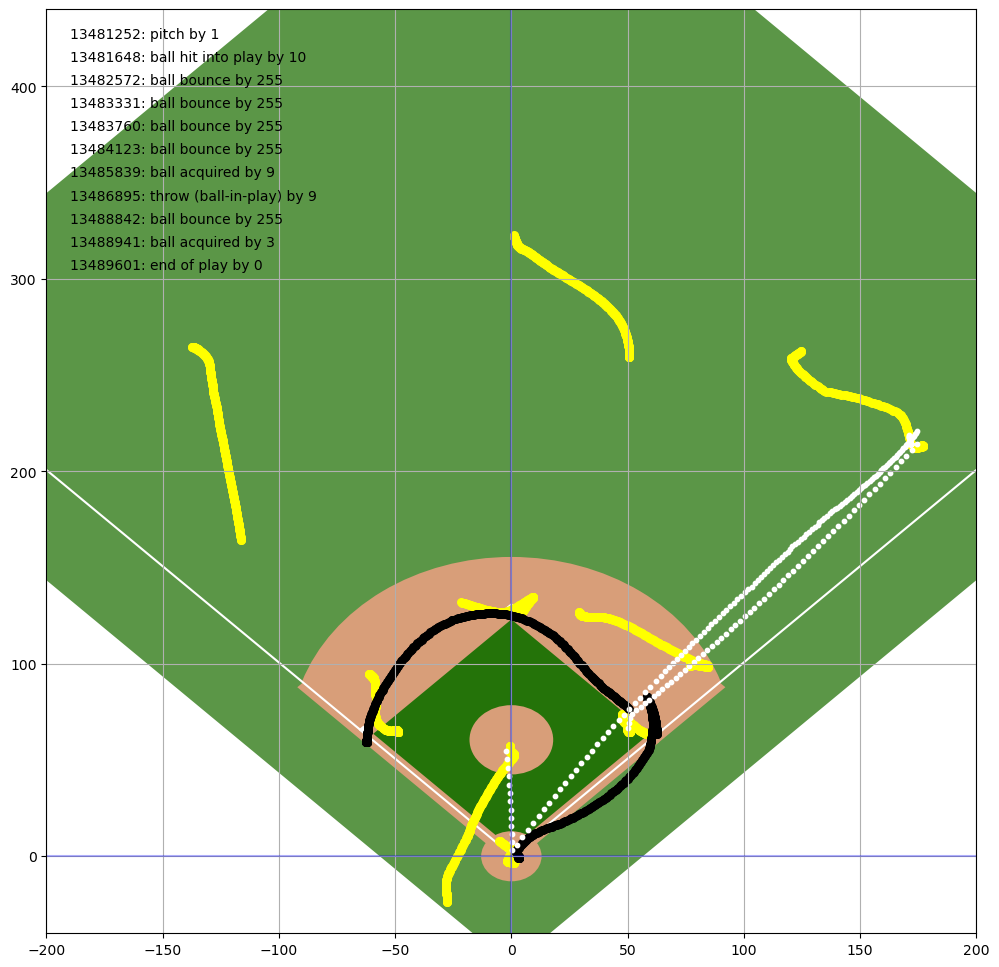

In [84]:
bf_1902_24.clear_plot()

play_id = bf_1902_24.game_obj.get_pid_from_ppg(383)

bf_1902_24.plot_all_components(play_id=play_id)
bf_1902_24.fig


# bf_1902_24.create_gif(play_id=play_id, tag="--3-1")

### Another data issue:
- there are sometimes no BR listed in the game_info, even though there is definitely a person on base
    - examples: 
        - 383 had someone get on but they aren't recorded
        - 386 shows a person on third

## Count how many times there are innings that mess up! 

In [ ]:
# get all games into a list, so I can use my Game class
all_games = {}

for sub_dir, dirs, files in os.walk('data/game_events/'):
    for file in files:
        if "checkpoint" in file:
                continue
    
        all_games[file.split("-")[-1].split(".csv")[0]] = {
            "num_valid_innings" : 0,
            "possible_half_innings" : 0
        }

# this returns 97        
print(len(all_games))     

In [ ]:
for which_game in all_games.keys():
    print("Which game: {}".format(which_game))

    bf = Baseball_Field(which_game)
    
    g = bf.game_obj


    full_game = g.game_info_df.copy()

    full_game["prev_outs"] = np.nan
    full_game["this_play_outs"] = np.nan


    full_game["n_br"] = full_game[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)

    # you know for certain that there are no outs when it is the first batter in the half inning
    switiching_sides_indices = full_game.loc[full_game["top_bottom_inning"].shift() != full_game["top_bottom_inning"]].index

    full_game.loc[switiching_sides_indices, "prev_outs"] = 0
    
    
    # make an array to store all of these
    running_outs_seq = np.full((full_game.shape[0], 2), -99)

    running_index = 0
    
    possible_half_innings = 0

    for inning in range(1, 10):
        # print(inning)

        for which_half in ["Top", "Bottom"]:

            # print(which_half)

            this_half = full_game.loc[(full_game["inning"] == inning) & (full_game["top_bottom_inning"] == which_half), :]


            if this_half.shape[0] == 0:
                print("no data for the {} of {}".format(which_half, inning))

                # TODO: this means that the home team def won in tghe inning is 9 -- maybe track this
                running_index += outs_seq.shape[0]
                continue

            outs_seq = this_half[["prev_outs", "this_play_outs"]].copy().values
            # print(outs_seq.shape)

            all_games[which_game]["possible_half_innings"] += 1
            
                                  
            solve_outs_sequence_seq(g, this_half, outs_seq)

            # the total number of outs made in a half inning must be 3
            try: 
            
                assert sum(outs_seq[:, 1]) == 3
                all_games[which_game]["num_valid_innings"] += 1

            except:
                print("Assetion Error: for the {} of {}".format(which_half, inning))
                
            
            if np.isnan(outs_seq).all():
                # this means something went wrong, fill -99 so it is obvious
                outs_seq = np.full(outs_seq.shape, -99)
                
                
            # fill in this sequence into the array
            running_outs_seq[(running_index): (running_index+outs_seq.shape[0]), :] = outs_seq

            running_index += outs_seq.shape[0]
            
            


    # assign the array back to those cols in the df
    full_game.loc[:, ["prev_outs", "this_play_outs"]] = running_outs_seq


In [ ]:
coverage_of_outs_df = pd.DataFrame(all_games).T

In [ ]:
coverage_of_outs_df.describe().loc["mean", "num_valid_innings"] / coverage_of_outs_df.describe().loc["mean", "possible_half_innings"]

#### Assessment of this:
- assertion errors in the 9th are walk offs
- No data after a certain inning mean the game was rain shortened or something

- some of those that don't have 
